In [1]:
# import modules
import datetime #, timedelta
import time
import json
import pandas as pd
import numpy as np
import decimal
from matplotlib import pyplot as plt
import seaborn as sns
import math
import scienceplots
import matplotlib 

# from plotly.subplots import make_subplots
import plotly.graph_objects as go

import boto3
from boto3.dynamodb.conditions import Key, Attr

# Obtain secret key for AWS
f = open("secret.txt")
text = f.readlines()

# Access dynamodb on AWS
dynamodb = boto3.resource(
    "dynamodb",
    aws_access_key_id=text[0][:-1],
    aws_secret_access_key=text[1][:-1],
    region_name="us-east-2",
)

    
plt.style.use(['science','ieee','high-vis'])
# plt.rcParams['axes.linewidth'] = 1
# plt.rcParams['figure.dpi'] =300

w = 3.3 
h = 2.5

plt.rcParams['figure.constrained_layout.use'] = True
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
high_vis_map = ["#0d49fb", "#e6091c", "#26eb47", "#8936df", "#fec32d", "#25d7fd"]

In [2]:
# Scan through all Sessions2 data to get session items
table = dynamodb.Table('Sessions2')
params = {'ProjectionExpression': "dcosId,userId,user_email,vehicle_model,vehicle_maxChgRate_W,siteId,stationId,connectTime,startChargeTime,Deadline,energyReq_Wh,estCost,reg_centsPerHr,sch_centsPerHr,sch_centsPerKwh,sch_centsPerOverstayHr,#Dur,DurationHrs,choice,regular,scheduled,cumEnergy_Wh,peakPower_W,power,lastUpdate",
          'ExpressionAttributeNames': {"#Dur":"Duration"}}

# Repeat scan until LastEvaluatedKey is None
start = time.time()
done = False
start_key = None
temp = []
while not done:
    if start_key:
        params['ExclusiveStartKey'] = start_key
    response = table.scan(**params)
    temp.extend(response.get('Items', []))
    print("Length of Scanned Items is {0} items".format(len(temp)))
    start_key = response.get('LastEvaluatedKey', None)
    done = start_key is None

# Print elapsed time
end = time.time()
elapsed_time_min = np.floor((end-start)/60)
elapsed_time_sec = (end-start) % 60
elapsed_time = "Elapsed time: %d minutes, %d seconds" % (elapsed_time_min, elapsed_time_sec)
print(elapsed_time)

# Create dataframe
session_df = pd.DataFrame(temp)
del temp


Length of Scanned Items is 698 items
Length of Scanned Items is 1414 items
Length of Scanned Items is 2122 items
Length of Scanned Items is 2833 items
Length of Scanned Items is 3369 items
Elapsed time: 0 minutes, 5 seconds


## Expected Energy Demand, Duration

In [3]:
session_df['connectTime']  = pd.to_datetime(session_df['connectTime'] )
session_df['startChargeTime']  = pd.to_datetime(session_df['startChargeTime'] )
session_df['Deadline']  = pd.to_datetime(session_df['Deadline'] )
session_df['lastUpdate']  = pd.to_datetime(session_df['lastUpdate'])
session_df = session_df.sort_values(by='connectTime')
session_df = session_df[session_df['siteId'] == 25]
session_df['interArrivalTime_min'] = session_df['connectTime'].diff().dt.seconds / 60
plot_df = session_df[session_df['connectTime'].dt.year >= 2022]
session_df['arrHour']=session_df['connectTime'].dt.hour

session_df['cumEnergy_Wh']=session_df['cumEnergy_Wh'].astype(float)
session_df['cumEnergy_KWh']=session_df['cumEnergy_Wh']/1000
session_df['DurationHrs'] = session_df['DurationHrs'].astype(float)

In [4]:
# 1. peakPower_W = 0 and cumEnergy_W = 0: delete  
session_df = session_df[(session_df["peakPower_W"]!=0) & (session_df["cumEnergy_Wh"]!=0)]

# 2. Fix the user peak_powers 
# some users have historical peak power > 6.6 / 7 
user_df = session_df[['userId','peakPower_W','vehicle_maxChgRate_W']].groupby('userId').max()
user_df['session_counts'] = session_df[['userId','peakPower_W']].groupby('userId').count()

validate_users = user_df[(user_df['session_counts']==1) & (user_df['peakPower_W']<=6000) ].index.to_list()
user_df.reset_index(drop=False,inplace=True)

user_df.rename(columns={"peakPower_W":'historical_peakPower_w'},inplace=True)
session_df = session_df.merge(user_df[['userId','historical_peakPower_w']])

In [5]:
optimizer_time = pd.Timestamp(2023, 2, 7, 8)
session_df['endTime'] = session_df['startChargeTime'] + pd.to_timedelta(session_df['Duration'])
cols = ['connectTime','choice','power','endTime','Duration', 'userId', 'Deadline', 'startChargeTime','DurationHrs','dcosId', 'lastUpdate' ]
session_df[(session_df['startChargeTime']>optimizer_time)].sort_values(by='connectTime')[cols]

connectTime     choice  \
950  2023-02-07 08:32:19    REGULAR   
2384 2023-02-07 08:39:32    REGULAR   
1814 2023-02-07 09:02:28  SCHEDULED   
1406 2023-02-07 09:19:18    REGULAR   
2017 2023-02-07 09:50:38    REGULAR   
...                  ...        ...   
2456 2023-03-22 09:13:43    REGULAR   
2484 2023-03-22 10:23:17    REGULAR   
2506 2023-03-22 14:39:32    REGULAR   
2425 2023-03-22 17:57:07    REGULAR   
2497 2023-03-22 20:13:57    REGULAR   

                                                  power             endTime  \
950        [{'power_W': 6736, 'timestamp': 1675812017}] 2023-02-07 15:20:17   
2384       [{'power_W': 6682, 'timestamp': 1675806309}] 2023-02-07 13:45:09   
1814       [{'power_W': 4497, 'timestamp': 1675810509}] 2023-02-07 14:55:09   
1406       [{'power_W': 3576, 'timestamp': 1675806309}] 2023-02-07 13:45:09   
2017       [{'power_W': 6624, 'timestamp': 1675809308}] 2023-02-07 14:35:08   
...                                                 ...                 ...   
2456       [{'power_W': 6383, 'timestamp': 1679514608}] 2023-03-22 12:50:08   
2484        [{'power_W': 265, 'timestamp': 1679527507}] 2023-03-22 16:25:07   
2506  [{'power_W': 3427, 'timestamp': 1679528708}, {... 2023-03-22 18:05:08   
2425  [{'power_W': 6589, 'timestamp': 1679533208}, {... 2023-03-22 20:45:08   
2497  [{'power_W': 0, 'timestamp': 1679544307}, {'po... 2023-03-22 22:15:07   

             Duration userId            Deadline     startChargeTime  \
950   0 days 06:47:48    792                 NaT 2023-02-07 08:32:29   
2384  0 days 05:03:48   1233                 NaT 2023-02-07 08:41:21   
1814  0 days 05:51:44   1126 2023-02-07 15:00:00 2023-02-07 09:03:25   
1406  0 days 04:24:03    988                 NaT 2023-02-07 09:21:06   
2017  0 days 04:44:16   1149                 NaT 2023-02-07 09:50:52   
...               ...    ...                 ...                 ...   
2456  0 days 03:35:39   1258                 NaT 2023-03-22 09:14:29   
2484  0 days 06:01:40   1271                 NaT 2023-03-22 10:23:27   
2506  0 days 03:24:59    790                 NaT 2023-03-22 14:40:09   
2425  0 days 02:47:04   1177                 NaT 2023-03-22 17:58:04   
2497  0 days 01:11:26   1276                 NaT 2023-03-22 21:03:41   

      DurationHrs dcosId          lastUpdate  
950       6.79666   4150 2023-02-07 15:20:17  
2384      5.06333   4151 2023-02-07 13:45:09  
1814      5.86222   4153 2023-02-07 14:55:09  
1406      4.40083   4154 2023-02-07 13:45:09  
2017      4.73777   4155 2023-02-07 14:35:08  
...           ...    ...                 ...  
2456      3.59416   4578 2023-03-22 12:50:08  
2484      6.02777   4579 2023-03-22 16:25:07  
2506      3.41638   4580 2023-03-22 18:05:08  
2425      2.78444   4581 2023-03-22 20:45:08  
2497      1.19055   4582 2023-03-22 22:15:07  

[218 rows x 11 columns]

In [6]:
high_power_idx = list(session_df[session_df['historical_peakPower_w'] >= 5000].index)
low_power_idx = list(session_df[session_df['historical_peakPower_w'] < 5000].index)

session_df['highPower'] = pd.Series(dtype=int)

session_df.loc[high_power_idx ,'highPower'] = 1
session_df.loc[low_power_idx ,'highPower'] = 0

session_df.loc[high_power_idx ,'userPower_kW'] = 6.6
session_df.loc[low_power_idx ,'userPower_kW'] = 3.3

In [7]:
plt.rcParams['figure.dpi'] =300

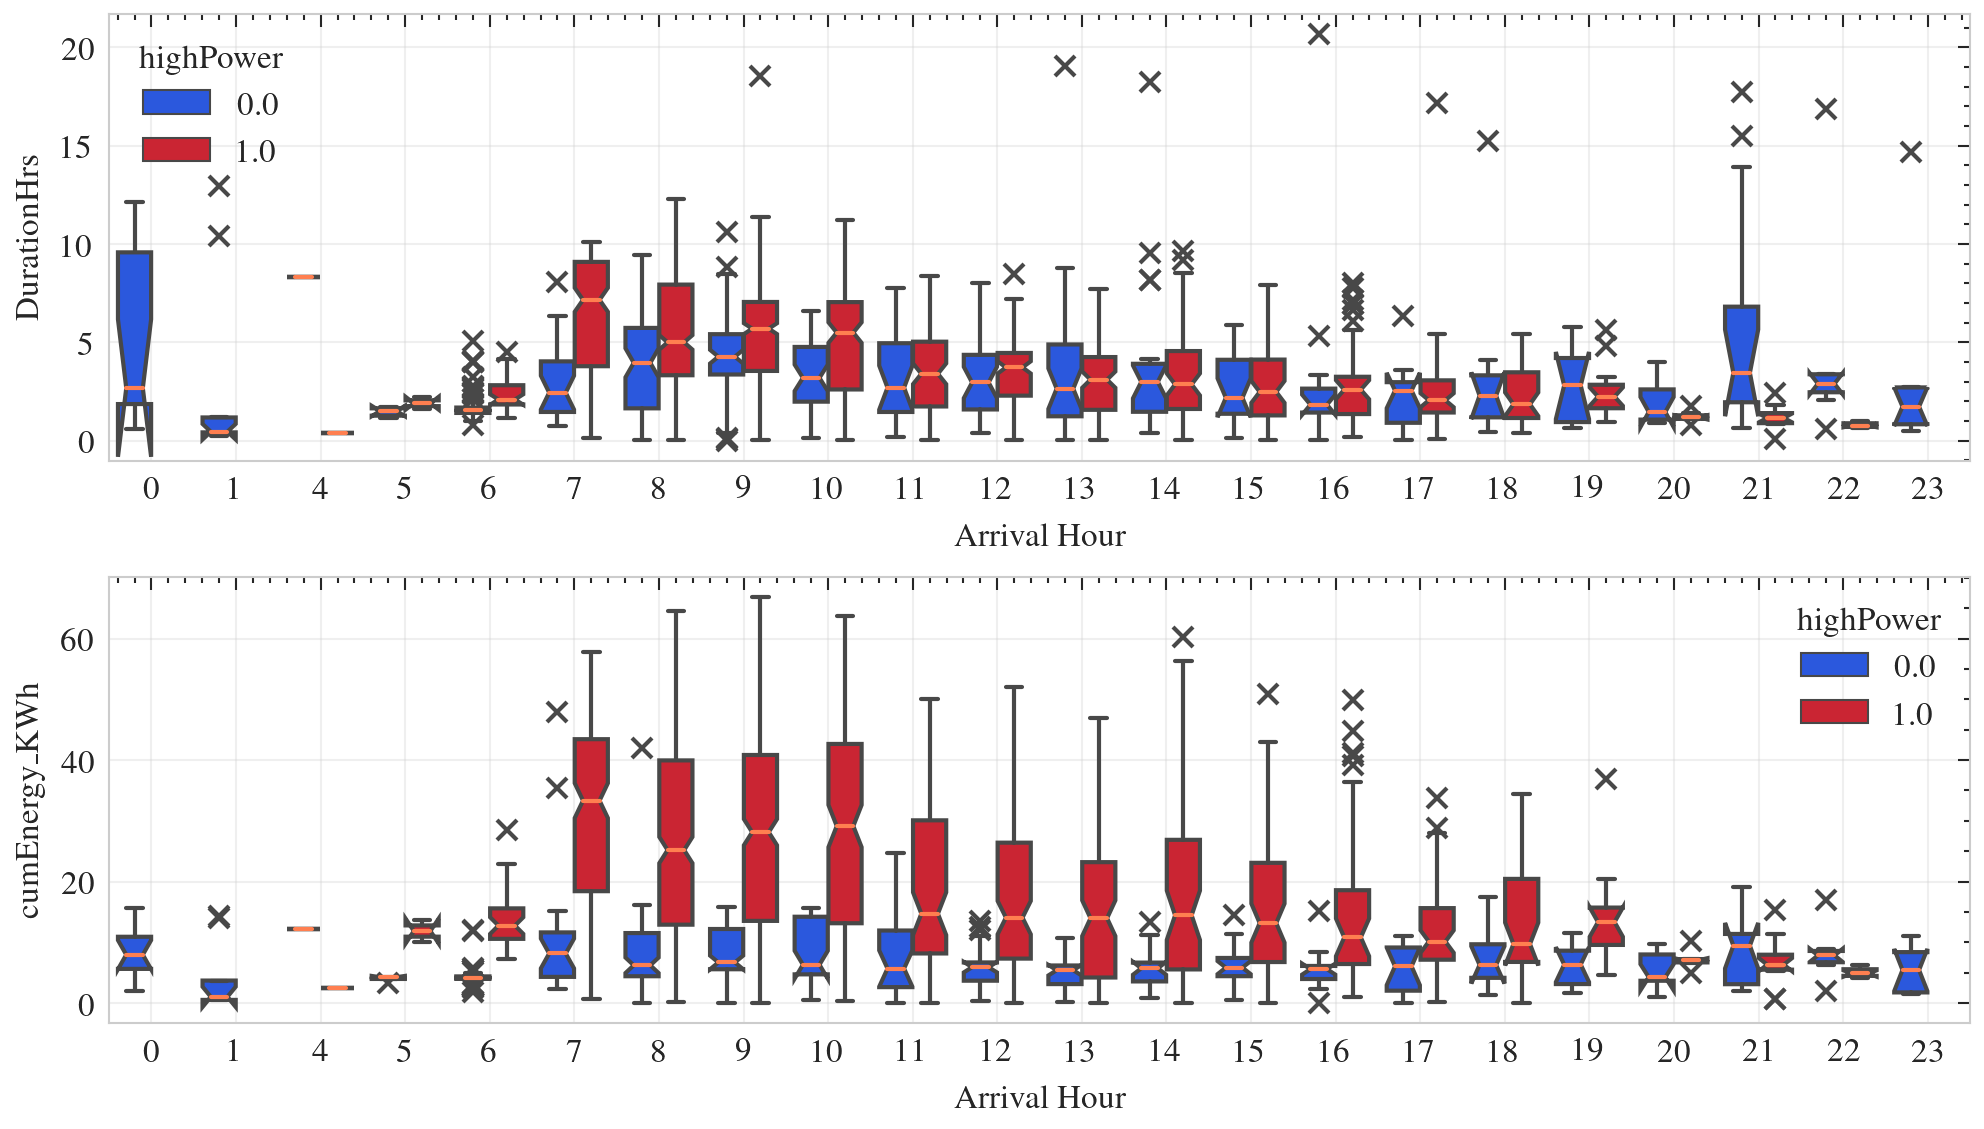

In [8]:
fig,ax= plt.subplots(2,1,figsize=( w*2, h*1.5 ))

sns.boxplot(
    data=session_df, x="arrHour", y="DurationHrs",hue='highPower',
    notch=True, showcaps=True,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},ax=ax[0]
)

sns.boxplot(
    data=session_df, x="arrHour", y="cumEnergy_KWh",hue='highPower',
    notch=True, showcaps=True,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},ax=ax[1]
)

for i in [0,1]:
    ax[i].grid(alpha=0.3)
    ax[i].set_xlabel("Arrival Hour")

In [9]:
iterables = [[0,1], range(0,24)]
idx = pd.MultiIndex.from_product(iterables, names=['highPower','arrHour'])
# pd.DataFrame(index=idx,columns = ['DurationHrs', 'cumEnergy_Wh', 'interArrivalTime_min', 'arrivalHour','cumEnergy_KWh', 'count'])
expected_demand = session_df.groupby(['highPower','arrHour']).mean()
expected_demand['count'] = session_df.groupby(['highPower','arrHour']).count()['dcosId']
expected_demand = expected_demand.reindex(idx).reset_index(drop=False)
expected_demand.rename(columns = {'cumEnergy_Wh':"estEnergyWh", 
                                  'cumEnergy_KWh':"estEnergykWh", 
                                  "DurationHrs":"estDurationHrs"},inplace=True)


expected_demand['count'].fillna(0,inplace=True)
# expected_demand.fillna(method='ffill',inplace=True)

C:\Users\Holiday\AppData\Local\Temp\ipykernel_16776\660894383.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  expected_demand = session_df.groupby(['highPower','arrHour']).mean()


In [10]:
for i in range(0, len(expected_demand), 24):
    group = expected_demand.iloc[i:i+24]
    group.fillna(method='ffill', inplace=True)
    group.fillna(method='bfill', inplace=True)

C:\Users\Holiday\AppData\Local\Temp\ipykernel_16776\4109480676.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group.fillna(method='ffill', inplace=True)
C:\Users\Holiday\AppData\Local\Temp\ipykernel_16776\4109480676.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group.fillna(method='bfill', inplace=True)


In [11]:
expected_demand

highPower  arrHour  estDurationHrs   estEnergyWh  interArrivalTime_min  \
0           0        0        5.115760   8349.500000            533.111111   
1           0        1        3.004533   4106.888889            376.848148   
2           0        2        3.004533   4106.888889            376.848148   
3           0        3        3.004533   4106.888889            376.848148   
4           0        4        8.323880  12213.000000            704.250000   
5           0        5        1.465440   3995.000000           1003.226667   
6           0        6        1.637458   4215.265306            993.837483   
7           0        7        2.987962  10562.772727            772.837121   
8           0        8        4.039089   8025.513158            352.328289   
9           0        9        4.323759   8331.211765            230.774510   
10          0       10        3.447951   8394.690476            189.639683   
11          0       11        3.273235   7362.291667            238.069444   
12          0       12        2.984597   5746.900000            206.529444   
13          0       13        3.930389   4789.967742            302.709677   
14          0       14        3.980643   5808.000000            207.106349   
15          0       15        2.593899   6417.052632            243.823684   
16          0       16        3.351166   5581.714286            259.906410   
17          0       17        2.343521   5738.538462            318.387179   
18          0       18        3.686488   7317.625000            344.945833   
19          0       19        2.895027   6121.333333            498.637037   
20          0       20        1.952245   5389.300000            273.710000   
21          0       21        5.805435   8705.583333            363.234722   
22          0       22        4.584003   8192.428571            462.207143   
23          0       23        3.002124   5354.111111            468.177778   
24          1        0        0.387770   2471.000000            501.550000   
25          1        1        0.387770   2471.000000            501.550000   
26          1        2        0.387770   2471.000000            501.550000   
27          1        3        0.387770   2471.000000            501.550000   
28          1        4        0.387770   2471.000000            501.550000   
29          1        5        1.907635  11853.500000           1084.550000   
30          1        6        2.389616  13414.606061            626.791414   
31          1        7        6.451677  31204.700535            414.230125   
32          1        8        5.401297  26885.357513            205.554016   
33          1        9        5.387103  28136.482323             92.707660   
34          1       10        5.009558  28210.028090            152.633521   
35          1       11        3.498435  19603.854167            189.842187   
36          1       12        3.512780  17325.789916            184.068768   
37          1       13        3.079798  15503.368932            220.054854   
38          1       14        3.388658  18278.411765            262.597059   
39          1       15        2.829422  15613.359375            205.497656   
40          1       16        2.966991  15947.342105            260.678070   
41          1       17        2.593873  11851.442308            274.938782   
42          1       18        2.321301  13171.864865            270.048649   
43          1       19        2.442565  13786.500000            224.791667   
44          1       20        1.224876   7162.142857            200.738095   
45          1       21        1.205015   6904.846154            349.557692   
46          1       22        0.800827   5065.818182            300.345455   
47          1       23        0.800827   5065.818182            300.345455   

    estEnergykWh  userPower_kW  count  
0       8.349500           3.3   12.0  
1       4.106889           3.3    9.0  
2       4.106889           3.3    0.0  
3       4.106889     

# Test Station Level Optimizer
Currently optimizer works only with the simulator. <br>
Start with the simple case: Run with no-on going sessions. 



In [12]:
import optimizer_station as opt
# We define the timesteps in the APP as 15 minute 
delta_t = 0.25 #hour 
print("For delta_t: ",delta_t, "max number of intervals:",24/delta_t)
################## Define the TOU Cost ##########################################
## the TOU cost is defined considering the delta_t above, if not code raises an error.##

# off-peak 0.175  cents / kwh 
TOU_tariff = np.ones((96,)) * 17.5
## 4 pm - 9 pm peak 0.367 cents / kwh 
TOU_tariff[64:84] = 36.7
## 9 am - 2 pm super off-peak 0.49 $ / kWh  to cents / kwh

TOU_tariff[36:56] = 14.9

For delta_t:  0.25 max number of intervals: 96.0


# Optimization with station information

In [13]:
optimizer_time = pd.Timestamp(2023, 3, 6, 7, 0, 0)
print(optimizer_time)
print(pd.to_datetime(optimizer_time).value)

2023-03-06 07:00:00
1678086000000000000


In [14]:
def unixTime(timeStamp):
    return int(pd.to_datetime(timeStamp).timestamp())

def dummyUserPower(choice):
    
    """ Returns Array but this can also be a dictionary """

    ### Yifei: In the optimizer, we require strictly that HIGH power corresponds to 6.6 kW and LOW power corresponds to 3.3 kW.
    ### Aka, for REG, we require the first several intervals to be 6.6 kW (must satisfy, cannot be other values like 6, 6, 6...)
    
    ts = pd.date_range(start = pd.Timestamp(2023, 3, 6, 7, 45, 0), periods=10, freq="15min")
    ts = [unixTime(t) for t in ts]
    
    p0 = 6600
    p1 = 6600
    p2 = 6600
    p3 = 6600
    p4 = 6600
    p5 = 3300

    if choice == "REG":
        
        ## Can you clarify up to what are we recording for the REG option? Is it the N_ASAP? 

        ## Yifei: Yes, the length of REG_powers should be the same with N_ASAP.
        powers = np.array([[ts[0], p0], 
                           [ts[1], p1], 
                           [ts[2], p2], 
                           [ts[3], p3], 
                           [ts[4], p4],
                           [ts[5], 3300]])

    elif choice == "SCH":
        powers = np.array([ [ts[0], 0], [ts[1], p1], [ts[2], p2], [ts[3], p3], [ts[4], p4],
                           [ts[5], 6600], [ts[6], 0], [ts[7], 0], [ts[8], 0], [ts[9], 0]])
    else:
        powers = np.zeros(shape=(6,2))
    return powers

def dummyStateRecord():
    """ 
    Returns: List of Dictionaries
    Each entry is a state dictionary with keys: 
    
    monthlyPeak, int
    timeStamp, int
    sessions, list of dictionaries with keys
    dcosId, int
    choice, string
    powerRate, string
    energyNeeded, float
    deadline, int
    optPower, array 
        """
    
    stateRecord = [
        {"monthlyPeak":18, 
         "timeStamp":unixTime(pd.Timestamp(2023, 3, 6, 7, 45, 0)), ## Last record TS(decision of the last vehicle)
         "sessions": [ 
             {
                "dcosId" : 1001,
                "choice": "SCH",
                "powerRate": "HIGH",
                "energyNeeded" : 8250,
                "deadline" : unixTime(pd.Timestamp(2023, 3, 6, 9, 45, 0)), # So here the values are all discretized to 15 min intervals?
                "optPower" : dummyUserPower("SCH") 
             }, 
             {
                "dcosId" : 1002,
                "choice": "REG",
                "powerRate": "HIGH",
                "energyNeeded" : 9075,
                "deadline" : unixTime(pd.Timestamp(2023, 3, 6, 10, 0, 0)),
                "optPower" : dummyUserPower("REG") 
             }, 
         ]
        }
    ]
    print(stateRecord[0]["sessions"][0]["optPower"][:,1].sum() * 0.25)
#     assert  == 3750
    
    return stateRecord

def arrHourList(arrHour, optHorizon):
    """ arrHour, int: current optimization hour
        optHorizon, int: how long to optimize in hours """ 
    if arrHour <= (24-optHorizon):
        overnight = False
        return list(range(arrHour,(arrHour+optHorizon))), overnight
    else: 
        lst = list(range(arrHour,24))
        lst.extend(list(range(0 , ((arrHour+optHorizon)-24) )))
        overnight = True
        ## Overnight charging: like [23, 0, 1, 2]

        return lst, overnight

## Input format convertion(from raw input data to the format of the optimizer)

In [15]:
import datetime
import copy
def data_format_convertion(stateRecords, opt_hour, delta_t):
    timezone = datetime.timezone(datetime.timedelta(hours=0))
    stateRecord = copy.deepcopy(stateRecords[0]["sessions"])
    if not stateRecord:
        return None
    # num_users = len(stateRecord)
    res = []
    for user in stateRecord:
        try: 
            user["optPower"] = user["optPower"].tolist()
        except AttributeError: 
            user["optPower"] = user["optPower"]
            
        user["power_rate"] = 6.6 if user["powerRate"] == "HIGH" else 3.3

        start_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][0][0]), timezone) # the timestamp of the first time slot
        user["start_time"] = float(start_time_obj.hour + start_time_obj.minute / 60)

        end_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][-1][0]), timezone) # Or retrieve the last time slot??
        user["end_time"] = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t
        if user["end_time"] <= opt_hour:
            continue

        user["optPower"] = np.round(np.array([x[1] for x in user["optPower"]]) / 1000, 2)
        user["price"] = 25 if user["choice"] == "SCH" else 30
        user["energyNeeded"] = float(user["energyNeeded"]) / 1000
        del(user["deadline"])
        res.append(user)

    return res

For stateRecords with multiple timestamps, do we sort it every time to make sure stateRecord[0] is the last timestamp?

Where should I check the status(are vehicles still in the station)? Inside or outside optimizer?

Also need the TOU(can be derived from start and deadline and global TOU) and prices for existing vehicles!

### Update the power profiles in the stateRecords according to the opt's output(post-processing)

If we only need to generate the price table, then we do not need to update the stateRecords(power profiles). However, once a new user comes and makes its decision, the power profile of existing users shall be updated.(Is it correct?)

In [16]:
def convertOutput(stateRecords, station_info, res, hour, user_choice, optTime):
    """ Convert the output to the original format """
    new_state = copy.deepcopy(stateRecords[0])

    new_state["monthlyPeak"] = round(res["new_peak_sch"][0], 2) if user_choice == "SCH" else round(res["new_peak_reg"][0], 2)

    # Update the timestamp. Tugba: What should be the timestamp here?
    if optTime.hour > hour: # If it is overnight.
        new_TimeStamp = optTime + datetime.timedelta(days=1)
        new_TimeStamp = new_TimeStamp.replace(hour=hour, minute=0, second=0)
    else:
        new_TimeStamp = optTime.replace(hour=hour, minute=0, second=0)
    new_state["timeStamp"] = unixTime(new_TimeStamp)

    # new_state["timeStamp"] = unixTime(pd.Timestamp(2023, 3, 6, hour, 0 , 0))
    finishing_list = []
    if new_state["sessions"]:
        for i, user in enumerate(new_state["sessions"]):
            # Changed this because we need an array for code to not break.. 
            # We can agree on a convention later
            user["optPower"] = recover_json_serialized_power_array(user["optPower"])
            timezone = datetime.timezone(datetime.timedelta(hours=0))
            end_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][-1][0]), timezone) # Or retrieve the last time slot??
            end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t
            if end_time <= hour:
                finishing_list.append(i)
                continue
            user_update = [d for d in station_info if d["dcosId"] == user["dcosId"]][0] # The updated user info from opt output
            TOU_idx = user_update["TOU_idx"]
            user["optPower"][TOU_idx:, 1] = (np.ceil(user_update["optPower"][TOU_idx:] * 1000)).astype(int) # Retaining the UNIXTIME and updating the power
    if finishing_list:
        # Remove the index in finishing_list from new_state["sessions"]
        new_state["sessions"] = [user for i, user in enumerate(new_state["sessions"]) if i not in finishing_list]
    new_user = dict()
    new_user["dcosId"] = "dummyUser"
    new_user["choice"] = user_choice  # This choice and OPT power / price are decided outside the optimizer
    new_user["powerRate"] = "HIGH" if res["power_rate"] >= 4 else "LOW"
    new_user["energyNeeded"] = int(1000 * res['e_need'])
    new_user["optPower"], new_state["aggPower"], new_user["deadline"] = powerOutput(res, user_choice, optTime)
    ## TO-DO: How to get the deadline? Is it the rounded and discretized time or the actual time? For example, 8:45(Rounded) / 8:47(Actual)?
    new_state["utilityCost"] = res["utility_cost_sch"] if user_choice == "SCH" else res["utility_cost_reg"]
    new_state["sessions"].append(new_user)

    return new_state

def powerOutput(res, user_choice, optTime):
    """ Convert the output to the original format """
    start_timestamp = res["time_start"] * delta_t
    start_timestamp_hour = int(start_timestamp)
    start_timestamp_minute = int((start_timestamp % 1) * 60)
    start_time = optTime.replace(hour=start_timestamp_hour, minute=start_timestamp_minute, second=0) # Start_time == optTime here.
    # start_time = datetime.datetime(2023, 3, 6, start_timestamp_hour, start_timestamp_minute, 0)
    t0 = unixTime(start_time)

    end_timestamp = res["time_end_SCH"] * delta_t if user_choice == "SCH" else res["time_end_REG"] * delta_t
    end_timestamp_hour = int(end_timestamp)
    end_timestamp_minute = int((end_timestamp % 1) * 60)
    if end_timestamp_hour >= 24:
        end_timestamp_hour -= 24
        end_time = optTime + datetime.timedelta(days=1)
        end_time = end_time.replace(hour=end_timestamp_hour, minute=end_timestamp_minute, second=0)
    else:
        end_time = optTime.replace(hour=end_timestamp_hour, minute=end_timestamp_minute, second=0)
    # end_time = datetime.datetime(2023, 3, 6, end_timestamp_hour, end_timestamp_minute, 0)
    t1 = unixTime(end_time)

    timestamps = np.arange(t0, t1, delta_t * 60 * 60).astype(int)   # In seconds, for example, 0.25 * 60 = 15min in seconds
    optPower = copy.deepcopy(res["sch_powers"]) * 1000 if user_choice == "SCH" else copy.deepcopy(res["reg_powers"]) * 1000
    optPower = optPower.astype(int)
    output_power = np.concatenate((timestamps.reshape(-1, 1), optPower.reshape(-1, 1)), axis=1)

    ## Here the max_timestamp is used to calculate the aggregated power(decide which interval has power)
    max_timestamp = res["time_max"] * delta_t
    max_timestamp_hour = int(max_timestamp)
    max_timestamp_minute = int((max_timestamp % 1) * 60)
    if max_timestamp_hour >= 24:
        max_timestamp_hour -= 24
        max_time = optTime + datetime.timedelta(days=1)
        max_time = max_time.replace(hour=max_timestamp_hour, minute=max_timestamp_minute, second=0)
    else:
        max_time = optTime.replace(hour=max_timestamp_hour, minute=max_timestamp_minute, second=0)
    # max_time = datetime.datetime(2023, 3, 6, max_timestamp_hour, max_timestamp_minute, 0)
    t2 = unixTime(max_time)

    timestamps_agg = np.arange(t0, t2, delta_t * 60 * 60).astype(int)
    aggPower = copy.deepcopy(res["sch_agg"]) * 1000 if user_choice == "SCH" else copy.deepcopy(res["reg_agg"]) * 1000
    aggPower = aggPower.astype(int)
    output_power_agg = np.concatenate((timestamps_agg.reshape(-1, 1), aggPower.reshape(-1, 1)), axis=1)

    return output_power, output_power_agg, t1


## Generate the expected demand price table

In [17]:
from collections import defaultdict

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def recover_json_serialized_power_array(json_serialized_item):
    return np.asarray(json_serialized_item)
    
def generateOptPricePowerFromDummyInput(expectedDemand, optTime):
    
    unixOptTime = unixTime(optTime)  ## Convert the optTime to unix time
    arrival_hour = optTime.hour

    # We only take the next 4 hours of the price table

    ## read the stateRecords last entry
    stateRecords = dummyStateRecord()
    stateRecords[0]["sessions"] = list()  ### Temperarily set the sessions to be empty!!!!

    try:
        expected_demand.set_index(['arrHour','highPower'], inplace=True)
    except KeyError:
        print("")
        
    States, expectedDemand = generateOptPricePower(stateRecords, expectedDemand, optTime, arrival_hour)
        
    return States, expectedDemand
    

def generateOptPricePower(stateRecords, 
                          expectedDemand,
                          optTime,
                          arrival_hour,
                          opt_horizon=4,):
    """
    Generate the expected demand price table
    optTime: The time when the re-optimization is triggered. pd.Timestamp.
    arrival_hour: The hour of optTime
    """

    States = defaultdict(dict)
    optHours, overnight = arrHourList(arrival_hour, optHorizon=opt_horizon)

    ## read the expected demand table
    for highPower in [0,1]:
        for hour in optHours:

            ## Here we are converting the optimization time to the arrival time
            hr = optTime.hour
            minute =  optTime.minute / 60

            arrival_time = hr + minute
            duration_hour = expected_demand.loc[(hour, highPower), 'estDurationHrs']
            e_need = expected_demand.loc[(hour, highPower), 'estEnergykWh']

            event = {
                "time": int(hour / delta_t), # Hour or Arrival_hour?
                "e_need": e_need,
                "duration": int(duration_hour / delta_t),
                "station_pow_max": 6.6,
                "user_power_rate": expected_demand.loc[(hour, highPower), 'userPower_kW'],
                "limit_reg_with_sch": False,
                "limit_sch_with_constant": False,
                "sch_limit": 0,
                "historical_peak": 10
            }

            stateRecord = data_format_convertion(stateRecords, hour, delta_t)
            par = opt.Parameters(z0 = np.array([30, 30, 1, 1]).reshape(4, 1),
                         Ts = delta_t,
                         eff = 1.0,
                         soft_v_eta = 1e-4,
                         opt_eps = 0.0001,
                         TOU = TOU_tariff,
                         demand_charge_cost=12)

            prb = opt.Problem(par=par, event=event)

            obj = opt.Optimization_station(par, prb, stateRecord, hour)
            station_info, res = obj.run_opt()

            # One of the indexes power level 
            # index hierarchy: hour -> powerLevel -> SCH 
            # json.dumps(States['hour8']['SCH'])
            States["hour" + str(hour) + "-" + str(highPower)]["SCH"] = convertOutput(stateRecords, station_info, res, hour, "SCH", optTime)
            States["hour" + str(hour) + "-" + str(highPower)]["REG"] = convertOutput(stateRecords, station_info, res, hour, "REG", optTime)

            ### Heyy so this is for US to be able to test. We won't do this type of output in the server
            # However we will send the Right hand side of the below lines.
            # RHS should be a state record, in the server it will be indexed by hour and power and choice
            expected_demand.loc[(hour, highPower), 'SCH_expected_power_W']= json.dumps(States["hour" + str(hour) + "-" + str(highPower)]['SCH'],
                                                                                 cls=NumpyEncoder)

            expected_demand.loc[(hour, highPower), 'REG_expected_power_W']= json.dumps(States["hour" + str(hour) + "-" + str(highPower)]['REG'],
                                                                                 cls=NumpyEncoder)

            ### How do we update the expected demand table? Make a slice for 4 hours or take the whole?
            reg_centsPerHr, sch_centsPerHr = res["reg_centsPerHr"], res['sch_centsPerHr']
            expected_demand.loc[(hour, highPower), 'sch_centsPerHr'] = sch_centsPerHr
            expected_demand.loc[(hour, highPower), 'reg_centsPerHr'] = reg_centsPerHr


    return States, expectedDemand

States, expected_demand = generateOptPricePowerFromDummyInput(expected_demand, 
                                          optTime = pd.Timestamp(2023, 3, 6, 8, 0, 0))

8250.0
After 2 iterations, we got -0.022874  improvement, and claim convergence.
The prices(SCH & REG) are 29.983102 30.015294
Too much time for iteration(iteration times exceed 50)
After 50 iterations, we got 0.013973  improvement, and claim convergence.
The prices(SCH & REG) are 31.434082 30.679962
Too much time for iteration(iteration times exceed 50)
After 50 iterations, we got 0.014061  improvement, and claim convergence.
The prices(SCH & REG) are 31.321837 30.565921
Too much time for iteration(iteration times exceed 50)
After 50 iterations, we got 0.012363  improvement, and claim convergence.
The prices(SCH & REG) are 31.321837 30.565925
After 5 iterations, we got -0.378212  improvement, and claim convergence.
The prices(SCH & REG) are 30.124677 30.079988
After 12 iterations, we got -0.372452  improvement, and claim convergence.
The prices(SCH & REG) are 30.274683 30.047904
After 12 iterations, we got -0.366673  improvement, and claim convergence.
The prices(SCH & REG) are 30.274

# Plot the power profiles

In [18]:
import json
import math
from analysis import plot_max_min_power, plot_arrival_departure

In [39]:
def plot_power_profiles(TOU_tariff, States, expected_demand, arrHour, highPower, delta_t=0.25):
    high_TOU = TOU_tariff * 6.6 if highPower == 1 else TOU_tariff * 3.3
    steps_in_hr = int(1 / delta_t)
    eff = 1
    interval_size_minutes = int(60 * delta_t)

    timezone = datetime.timezone(datetime.timedelta(hours=0))

    station_pow_max = 6.6
    power_rate = 3.3 if highPower == 0 else 6.6

    e_need = expected_demand.loc[(arrHour, highPower) ,"estEnergykWh"]
    duration = expected_demand.loc[(arrHour, highPower) ,"estDurationHrs"]

    # Plot the power profiles for all users

    sch_power_list = []
    reg_power_list = []

    # If the new user chooses "SCH" mode

    for user in States["hour" + str(arrHour) + "-" + str(highPower)]["SCH"]["sessions"]:
        start_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][0][0]), timezone)
        start_time = float(start_time_obj.hour + start_time_obj.minute / 60)
        arrival_interval = int(start_time * steps_in_hr) # local control stamp within a day

        end_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][-1][0]), timezone)

        day_diff = end_time_obj.day - start_time_obj.day
        if day_diff > 0:
            end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t + 24 * day_diff
        else:
            end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t
        end_interval = int(end_time * steps_in_hr) # local control stamp

        num_intervals = int(24 * steps_in_hr * day_diff) if day_diff > 0 else int(24 * steps_in_hr)

        sch_arr = np.zeros((num_intervals, 1)) # Overnight scenario

        duration_interval = end_interval - arrival_interval

        timerange_sch = pd.date_range("1/1/2021", periods=num_intervals, freq="{}min".format(interval_size_minutes))
        sch_arr[arrival_interval:(arrival_interval+duration_interval)] = (user["optPower"][:, 1].reshape((duration_interval,1))) / 1000
        sch_power_list.append(sch_arr)

        # concatenate the high_TOU with day_diff times
        if day_diff > 0:
            high_TOU_sch = np.concatenate([high_TOU for _ in range(day_diff)])
        else:
            high_TOU_sch = high_TOU

    ## If the new user chooses the "REG" mode

    for user in States["hour" + str(arrHour) + "-" + str(highPower)]["REG"]["sessions"]:
        start_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][0][0]), timezone)
        start_time = float(start_time_obj.hour + start_time_obj.minute / 60)
        arrival_interval = int(start_time * steps_in_hr)

        end_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][-1][0]), timezone)

        day_diff = end_time_obj.day - start_time_obj.day
        if day_diff > 0:
            end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t + 24 * day_diff
        else:
            end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t
        end_interval = int(end_time * steps_in_hr) # local control stamp

        num_intervals = int(24 * steps_in_hr * day_diff) if day_diff > 0 else int(24 * steps_in_hr)

        reg_arr = np.zeros((num_intervals, 1)) # Overnight scenario

        duration_interval = end_interval - arrival_interval
        timerange_reg = pd.date_range("1/1/2021", periods=num_intervals, freq="{}min".format(interval_size_minutes))

        reg_arr[arrival_interval:(arrival_interval+duration_interval)] = (user["optPower"][:, 1].reshape((duration_interval,1))) / 1000
        reg_power_list.append(reg_arr)

        high_TOU_reg = np.concatenate([high_TOU for _ in range(day_diff)]) if day_diff > 0 else high_TOU

    # Plots Settings

    fig,(ax1, ax2, ax3) = plt.subplots(3,1,figsize=(12,7) ,)

    for i, profile in enumerate(reg_power_list):
        ax1.plot(timerange_reg, profile, label = "User " + str(States["hour" + str(arrHour) + "-" + str(highPower)]["REG"]["sessions"][i]["dcosId"]) + "(" + str(States["hour" + str(arrHour) + "-" + str(highPower)]["REG"]["sessions"][i]["choice"]) + ")", linestyle = "-", linewidth = 2)
    ax = ax1.twinx()
    ax.plot(timerange_reg , high_TOU_reg, label = 'TOU Cost', color = 'blue', ms=0, marker ='X', linestyle = "--")


    reg_price_cents_hour = np.round(expected_demand.loc[(arrHour, 0), 'reg_centsPerHr'], 2)
    ax.axhline(reg_price_cents_hour, linestyle='--',color='red',
               label ="OPT REG Tariff" + "(" + str(reg_price_cents_hour) + ")")
    ax.legend(loc=3)
    ax.set_ylabel("Tariff(cent/hour)")
    # ax.set_ylim(40,200)
    ax.title.set_text("Power Profiles if New REG User" + " (Peak:" + str(States["hour" + str(arrHour) + "-" + str(highPower)]["REG"]["monthlyPeak"])+ ")")

    for i, profile in enumerate(sch_power_list):
        ax2.plot(timerange_sch, profile, label = "User " + str(States["hour" + str(arrHour) + "-" + str(highPower)]["SCH"]["sessions"][i]["dcosId"]) + "(" + str(States["hour" + str(arrHour) + "-" + str(highPower)]["SCH"]["sessions"][i]["choice"]) + ")", linestyle = "-", linewidth = 2)
    ax = ax2.twinx()
    sch_price_cents_hour = np.round(expected_demand.loc[(arrHour, 0), 'sch_centsPerHr'], 2)
    ax.plot(timerange_sch , high_TOU_sch, label = 'TOU Cost', color = 'blue', ms=0,marker ='X',linestyle = "--")
    ax.axhline(sch_price_cents_hour  ,linestyle='--',color='red',
               label ="OPT SCH Tariff" + "(" + str(sch_price_cents_hour) + ")")
    ax.legend(loc=3)
    ax.set_ylabel("Tariff (cent/hour)")
    # ax.set_ylim(40,200)
    ax.title.set_text("Power Profiles if New SCH User" + " (Peak:" + str(States["hour" + str(arrHour) + "-" + str(highPower)]["SCH"]["monthlyPeak"]) + ")")
    plot_arrival_departure([ax1,ax2], arrHour, 0, int(arrHour + duration),
                           int(60 * ((arrHour + duration) % int(arrHour + duration))))

    # Plot the aggregated power profile

    # Plot aggregated power profile
    start_time_obj = datetime.datetime.fromtimestamp(int(States["hour" + str(arrHour) + "-" + str(highPower)]["SCH"]["aggPower"][0][0]), timezone)
    start_time = float(start_time_obj.hour + start_time_obj.minute / 60)
    arrival_interval = int(start_time * steps_in_hr)

    end_time_obj = datetime.datetime.fromtimestamp(int(States["hour" + str(arrHour) + "-" + str(highPower)]["SCH"]["aggPower"][-1][0]), timezone)
    day_diff = end_time_obj.day - start_time_obj.day
    if day_diff > 0:
        end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t + 24 * day_diff
    else:
        end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t
    end_interval = int(end_time * steps_in_hr)
    duration_interval = end_interval - arrival_interval

    num_intervals_sch = int(24 * steps_in_hr * day_diff) if day_diff > 0 else int(24 * steps_in_hr)

    sch_agg = np.zeros((num_intervals_sch, 1)) # Overnight scenario

    sch_agg[arrival_interval:(arrival_interval+duration_interval)] = (States["hour" + str(arrHour) + "-" + str(highPower)]["SCH"]["aggPower"][:, 1].reshape((duration_interval,1))) / 1000


    start_time_obj = datetime.datetime.fromtimestamp(int(States["hour" + str(arrHour) + "-" + str(highPower)]["REG"]["aggPower"][0][0]), timezone)
    start_time = float(start_time_obj.hour + start_time_obj.minute / 60)
    arrival_interval = int(start_time * steps_in_hr)

    end_time_obj = datetime.datetime.fromtimestamp(int(States["hour" + str(arrHour) + "-" + str(highPower)]["REG"]["aggPower"][-1][0]), timezone)

    day_diff = end_time_obj.day - start_time_obj.day
    if day_diff > 0:
        end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t + 24 * day_diff
    else:
        end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t
    end_interval = int(end_time * steps_in_hr) # local control stamp

    num_intervals_reg = int(24 * steps_in_hr * day_diff) if day_diff > 0 else int(24 * steps_in_hr)

    reg_agg = np.zeros((num_intervals_reg, 1)) # Overnight scenario

    duration_interval = end_interval - arrival_interval


    reg_agg[arrival_interval:(arrival_interval+duration_interval)] = (States["hour" + str(arrHour) + "-" + str(highPower)]["REG"]["aggPower"][:, 1].reshape((duration_interval, 1))) / 1000

    timerange = pd.date_range("1/1/2021", periods=max(num_intervals_reg, num_intervals_sch), freq="{}min".format(interval_size_minutes))

    ax3.plot(timerange, sch_agg, label = "SCH", linestyle = "-", linewidth = 2)
    ax3.plot(timerange, reg_agg, label = "REG", linestyle = "-", linewidth = 2)

    ax3.set_title("Aggregated Power Profiles")

    plot_arrival_departure([ax3], arrHour, 0, int(arrHour + duration),
                           int(60 * ((arrHour + duration) % int(arrHour + duration))))

    ax = ax3.twinx()
    ax.axhline(States["hour" + str(arrHour) + "-" + str(highPower)]["SCH"]["utilityCost"] ,linestyle='--',color='blue',
               label ="Utility cost: " + str(round(States["hour" + str(arrHour) + "-" + str(highPower)]["SCH"]["utilityCost"], 2)) + "cents")

    ax.axhline(States["hour" + str(arrHour) + "-" + str(highPower)]["REG"]["utilityCost"] ,linestyle='--',color='red',
               label ="Utility cost: " + str(round(States["hour" + str(arrHour) + "-" + str(highPower)]["REG"]["utilityCost"], 2)) + "cents")
    ax.set_ylabel("Utility cost(cents)")
    ax.legend(loc=3)
    for ax in [ax1,ax2,ax3]:
        # ax.set_ylim(-0.5,7)
        ax.legend(loc=0)
        ax.set_xlabel("Time")
        ax.set_ylabel("Power (kW)")
    # ax3.set_ylim(-0.5,30)

    fig.suptitle("Hour " + str(arrHour))

In [20]:
## Dummy inputs 
cols =  ['sch_centsPerHr','reg_centsPerHr',
        'connectTime','Duration', 'Deadline', 'startChargeTime', 
     'sch_centsPerKwh','sch_centsPerOverstayHr', 'choice','DurationHrs',
       'dcosId', 'lastUpdate', 'energyReq_Wh','cumEnergy_Wh',  
         'interArrivalTime_min','arrHour', 'cumEnergy_KWh', 
         'historical_peakPower_w','userPower_kW','highPower']

### Change the optTime to test different dates, also change the row indices in for loop
optTime = pd.Timestamp(2023, 3, 9, 6, 0, 0)

subset = session_df[session_df['startChargeTime'] > optTime][cols].sort_values(by="startChargeTime")
subset.reset_index(drop=False,inplace=True)

_, expected_demand = generateOptPricePowerFromDummyInput(expected_demand,
                                          optTime = optTime)

8250.0

After 46 iterations, we got 0.000000  improvement, and claim convergence.
The prices(SCH & REG) are 31.122530 30.467388
Too much time for iteration(iteration times exceed 50)
After 50 iterations, we got 0.932540  improvement, and claim convergence.
The prices(SCH & REG) are 31.703655 31.024298
After 2 iterations, we got -0.022874  improvement, and claim convergence.
The prices(SCH & REG) are 29.983102 30.015294
Too much time for iteration(iteration times exceed 50)
After 50 iterations, we got 0.013973  improvement, and claim convergence.
The prices(SCH & REG) are 31.434082 30.679962
After 10 iterations, we got -0.143854  improvement, and claim convergence.
The prices(SCH & REG) are 30.242720 30.054394
After 27 iterations, we got -0.458725  improvement, and claim convergence.
The prices(SCH & REG) are 30.191562 30.065407
After 5 iterations, we got -0.378212  improvement, and claim convergence.
The prices(SCH & REG) are 30.124677 30.079988
After 12 iterations, we got -0.372452  i

In [21]:
def get_new_state(expected_demand, new_session_start):
    new_State = expected_demand.loc[(new_session_start.hour, 0),
                                   "SCH_expected_power_W"]
    new_State = json.loads(new_State)

    for session in new_State['sessions']:
        if session['dcosId'] == 'dummyUser':
            new_State['sessions'].remove(session)

        if session['deadline'] <= unixTime(new_session_start):
            print(pd.to_datetime(session['deadline'])," <= ",unixTime(new_session_start))
            print("removed session:",session['dcosId']) ## Check if it is removing correct or wrong session!!
            new_State['sessions'].remove(session)
    return new_State

In [22]:
subset

index sch_centsPerHr reg_centsPerHr         connectTime         Duration  \
0    2221            200            150 2023-03-09 06:36:11  0 days 03:33:58   
1    2481            200            150 2023-03-09 09:57:37  0 days 09:32:22   
2    2501            200            150 2023-03-09 19:13:16  0 days 02:09:52   
3    2222            200            150 2023-03-10 06:46:58  0 days 03:33:00   
4    2388            200            150 2023-03-10 08:53:50  0 days 03:20:10   
..    ...            ...            ...                 ...              ...   
56   2456            200            150 2023-03-22 09:13:43  0 days 03:35:39   
57   2484            200            150 2023-03-22 10:23:17  0 days 06:01:40   
58   2506            200            150 2023-03-22 14:39:32  0 days 03:24:59   
59   2425            NaN            NaN 2023-03-22 17:57:07  0 days 02:47:04   
60   2497            200            150 2023-03-22 20:13:57  0 days 01:11:26   

   Deadline     startChargeTime sch_centsPerKwh sch_centsPerOverstayHr  \
0       NaT 2023-03-09 06:36:17               0                    300   
1       NaT 2023-03-09 09:57:47               0                    300   
2       NaT 2023-03-09 19:15:16               0                    300   
3       NaT 2023-03-10 06:47:08               0                    300   
4       NaT 2023-03-10 08:54:58               0                    300   
..      ...                 ...             ...                    ...   
56      NaT 2023-03-22 09:14:29               0                    300   
57      NaT 2023-03-22 10:23:27               0                    300   
58      NaT 2023-03-22 14:40:09               0                    300   
59      NaT 2023-03-22 17:58:04             NaN                    NaN   
60      NaT 2023-03-22 21:03:41               0                    300   

     choice  ...  dcosId          lastUpdate energyReq_Wh cumEnergy_Wh  \
0   REGULAR  ...    4448 2023-03-09 10:10:15          NaN      15396.0   
1   REGULAR  ...    4451 2023-03-09 19:30:09          NaN      55537.0   
2   REGULAR  ...    4455 2023-03-09 21:25:08          NaN      13904.0   
3   REGULAR  ...    4456 2023-03-10 10:20:08          NaN      15585.0   
4   REGULAR  ...    4460 2023-03-10 12:15:08          NaN      21132.0   
..      ...  ...     ...                 ...          ...          ...   
56  REGULAR  ...    4578 2023-03-22 12:50:08          NaN      21780.0   
57  REGULAR  ...    4579 2023-03-22 16:25:07          NaN      32176.0   
58  REGULAR  ...    4580 2023-03-22 18:05:08          NaN      11132.0   
59  REGULAR  ...    4581 2023-03-22 20:45:08          NaN      17529.0   
60  REGULAR  ...    4582 2023-03-22 22:15:07          NaN       7175.0   

    interArrivalTime_min  arrHour  cumEnergy_KWh  historical_peakPower_w  \
0             905.350000        6         15.396                    6852   
1              69.783333        9         55.537                    6842   
2             419.900000       19         13.904                    6916   
3             693.700000        6         15.585                    6852   
4              47.883333        8         21.132                    6825   
..                   ...      ...            ...                     ...   
56             59.533333        9         21.780                    6891   
57             69.566667       10         32.176                    6842   
58            256.250000       14         11.132                    3429   
59            197.583333       17         17.529                    6669   
60            136.833333       20          7.175                    6893   

   userPower_kW  highPower  
0           6.6        1.0  
1           6.6        1.0  
2           6.6        1.0  
3           6.6        1.0  
4           6.6        1.0  
..          ...        ...  
56          6.6        1.0  
57          6.6        1.0  
58          3.3        0.0  
59          6.6        1.0  
60          6.6        1.0  

[61

In [23]:
# Real inputs

## Row: 0, 9, 17
last_opt_time = optTime

for row in subset.index[:1]:
    print("")
    print("Now we are optimizing for row:",row,"at time:",subset.loc[row,"startChargeTime"])
    print("")
    new_session_start = subset.loc[row,"startChargeTime"]
    new_session_choice = subset.loc[row,"choice"]
    new_session_id = subset.loc[row,"dcosId"]
    new_session_power = subset.loc[row,"highPower"]

    arrHour = new_session_start.hour
    curr_opt_time = new_session_start.replace(minute=0, second=0)
    opt_horizon = 4
    while curr_opt_time - last_opt_time > pd.Timedelta(hours=opt_horizon):
        new_State = get_new_state(expected_demand, last_opt_time)
        last_opt_time += pd.Timedelta(hours=opt_horizon) # Re-optimize every 4 hours
        stateRecords = [new_State] # States at the last opt hour
        States, expected_demand = generateOptPricePower(stateRecords,
                              expected_demand,
                              last_opt_time,
                              last_opt_time.hour)

    arrHour = new_session_start.hour
    new_State = expected_demand.loc[(new_session_start.hour, new_session_power),
                                   new_session_choice[:3]+ "_expected_power_W"]

    new_State = json.loads(new_State)

    for session in new_State['sessions']:
        if session['dcosId'] == 'dummyUser':
            session['dcosId'] = str(new_session_id)

        if session['deadline'] <= unixTime(new_session_start):
            print(pd.to_datetime(session['deadline'])," <= ",unixTime(new_session_start))
            print("removed session:",session['dcosId']) ## Check if it is removing correct or wrong session!!
            new_State['sessions'].remove(session)


    ### Identify the users at the Station
    optTime = new_session_start

    unixOptTime = unixTime(optTime)
    arrival_hour = optTime.hour

    # We only take the next 4 hours of the price table

    optHours, overnight = arrHourList(arrival_hour, optHorizon=4)
    ## read the stateRecords last entry
    stateRecords = [new_State]

    try:
        expected_demand.set_index(['arrHour','highPower'], inplace=True)
    except KeyError:
        print("")
    
    States, expected_demand = generateOptPricePower(stateRecords, 
                              expected_demand,
                              optTime, 
                              arrival_hour)
    last_opt_time = optTime


Now we are optimizing for row: 0 at time: 2023-03-09 06:36:17


After 11 iterations, we got -0.016643  improvement, and claim convergence.
The prices(SCH & REG) are 30.457921 30.188788
After 49 iterations, we got 0.000000  improvement, and claim convergence.
The prices(SCH & REG) are 31.249423 30.579442
After 2 iterations, we got -0.022886  improvement, and claim convergence.
The prices(SCH & REG) are 29.983100 30.015291
Too much time for iteration(iteration times exceed 50)
After 50 iterations, we got 0.013973  improvement, and claim convergence.
The prices(SCH & REG) are 31.434082 30.679962
After 2 iterations, we got 0.000001  improvement, and claim convergence.
The prices(SCH & REG) are 30.003079 29.999097
After 2 iterations, we got -0.072798  improvement, and claim convergence.
The prices(SCH & REG) are 29.968408 30.007374
After 4 iterations, we got -0.381264  improvement, and claim convergence.
The prices(SCH & REG) are 30.116896 30.081772
After 12 iterations, we got -0.372452  i

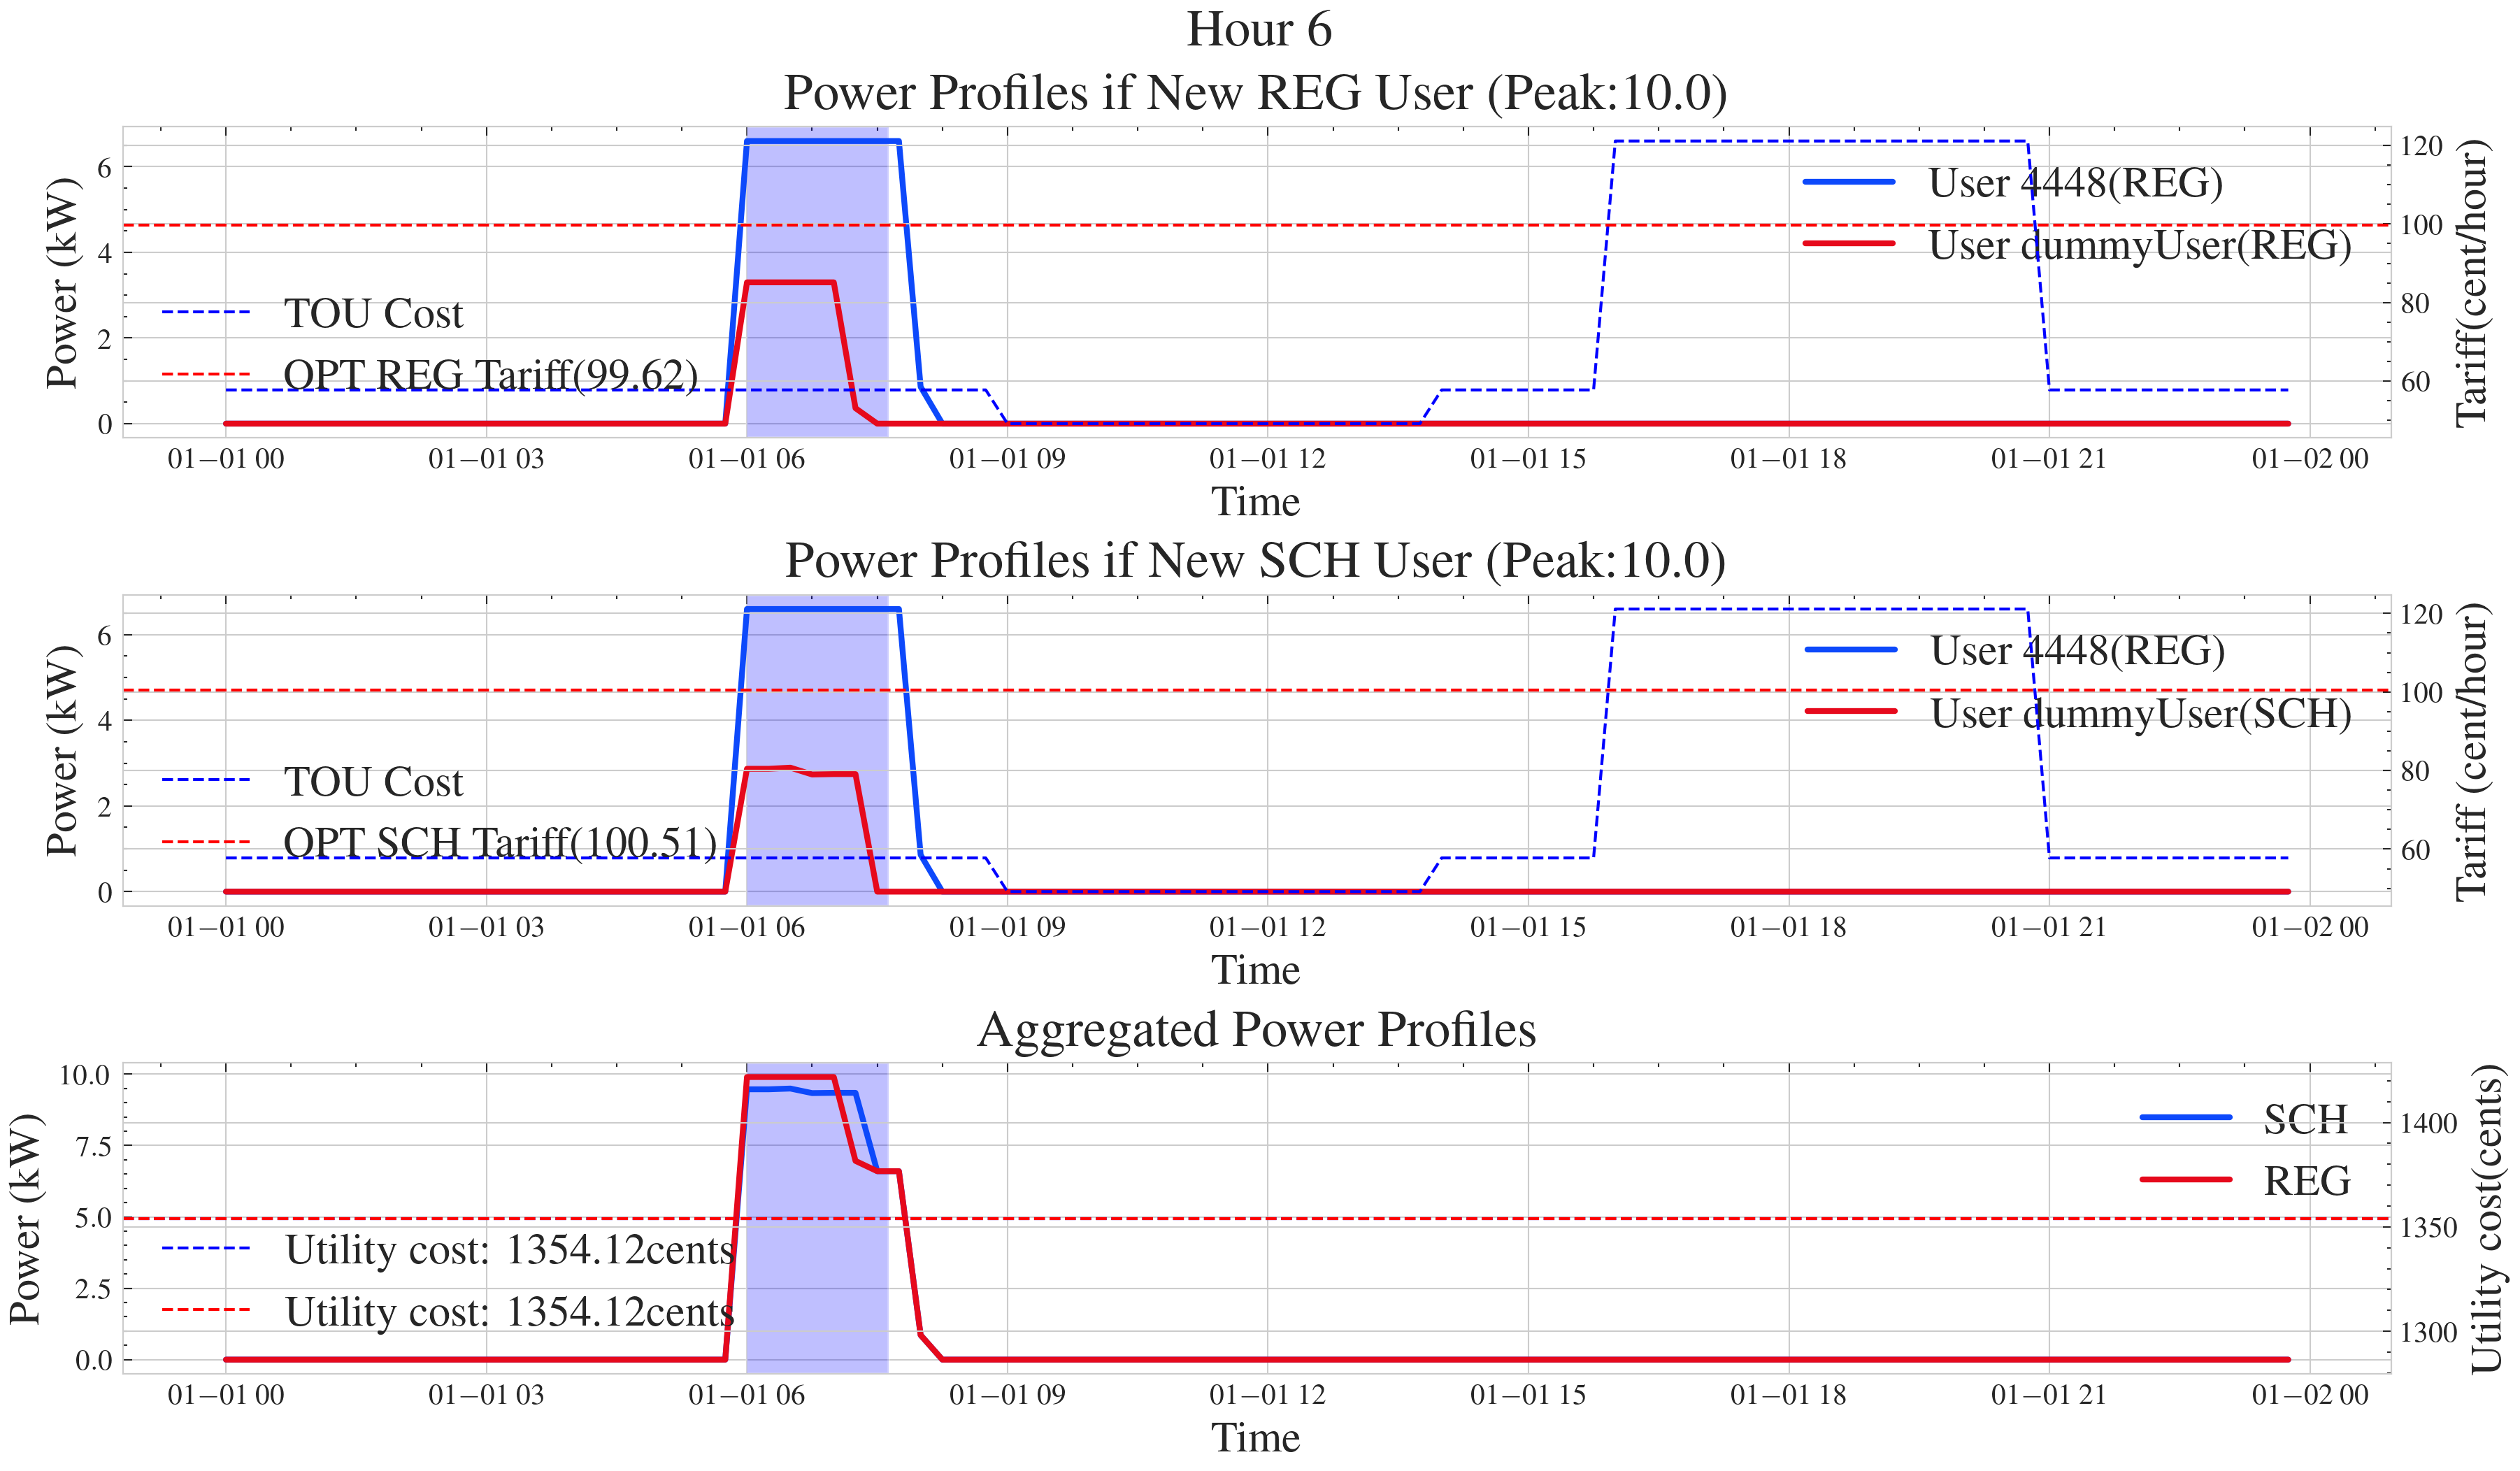

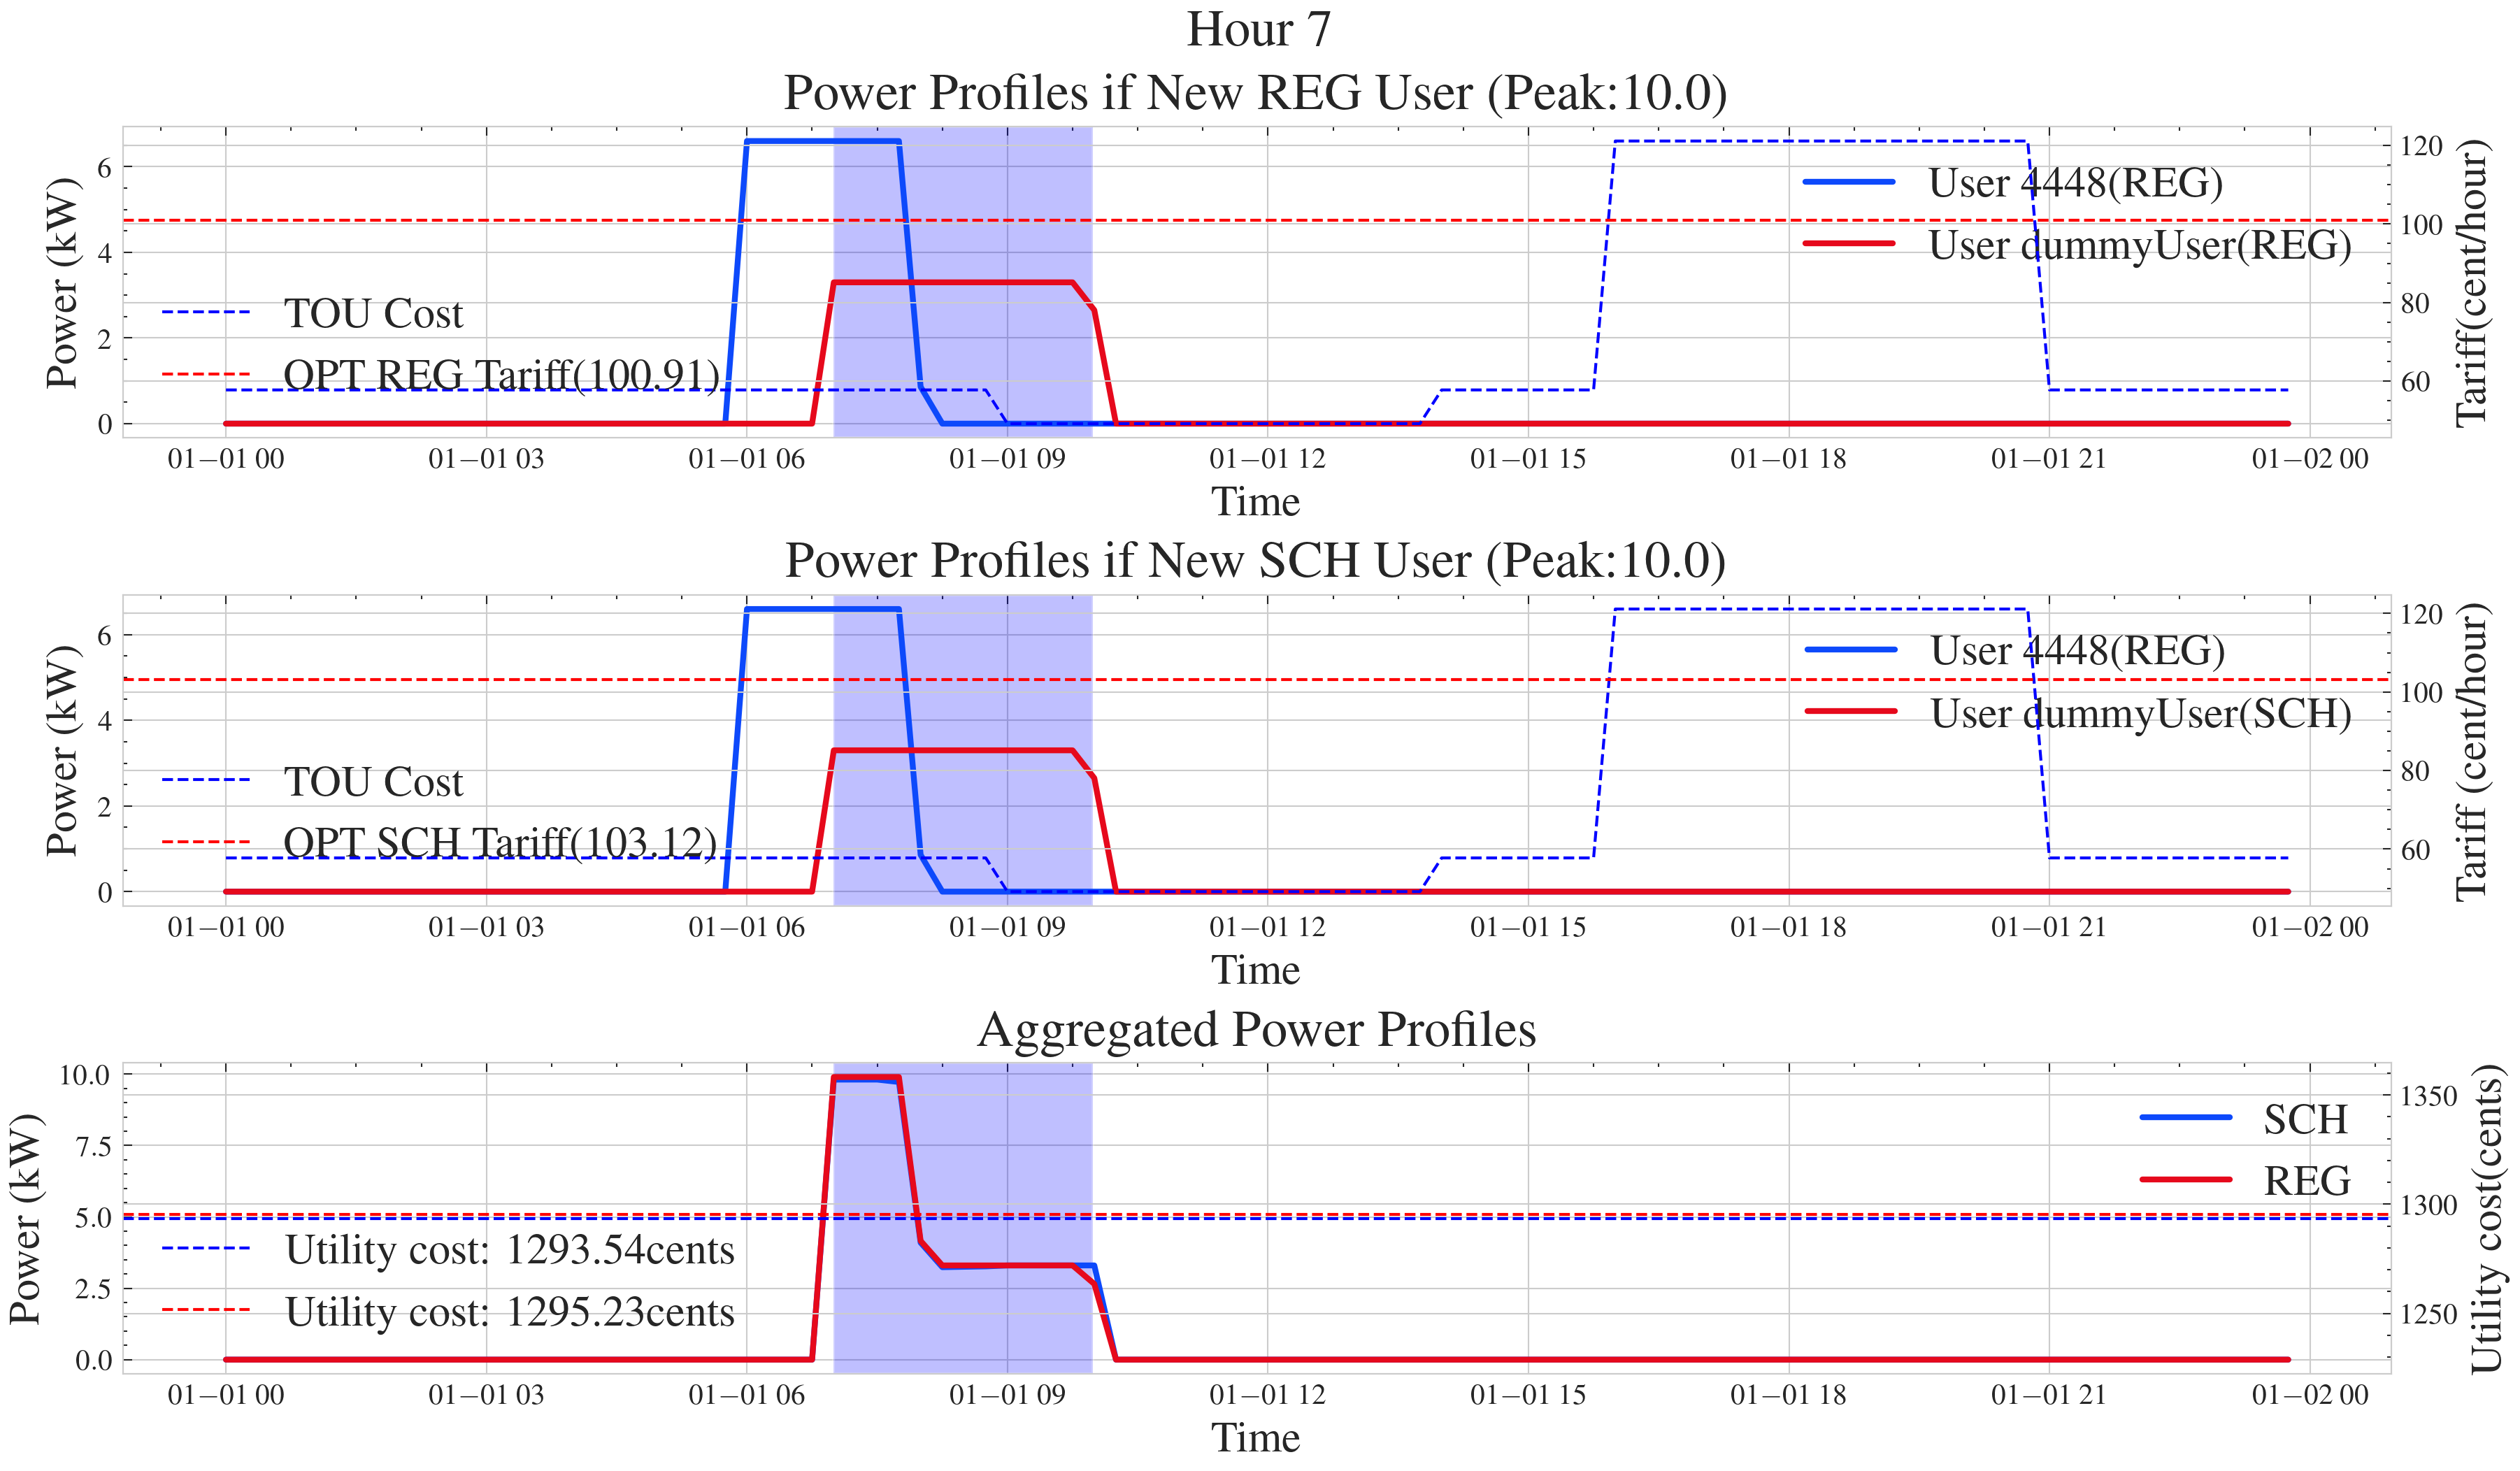

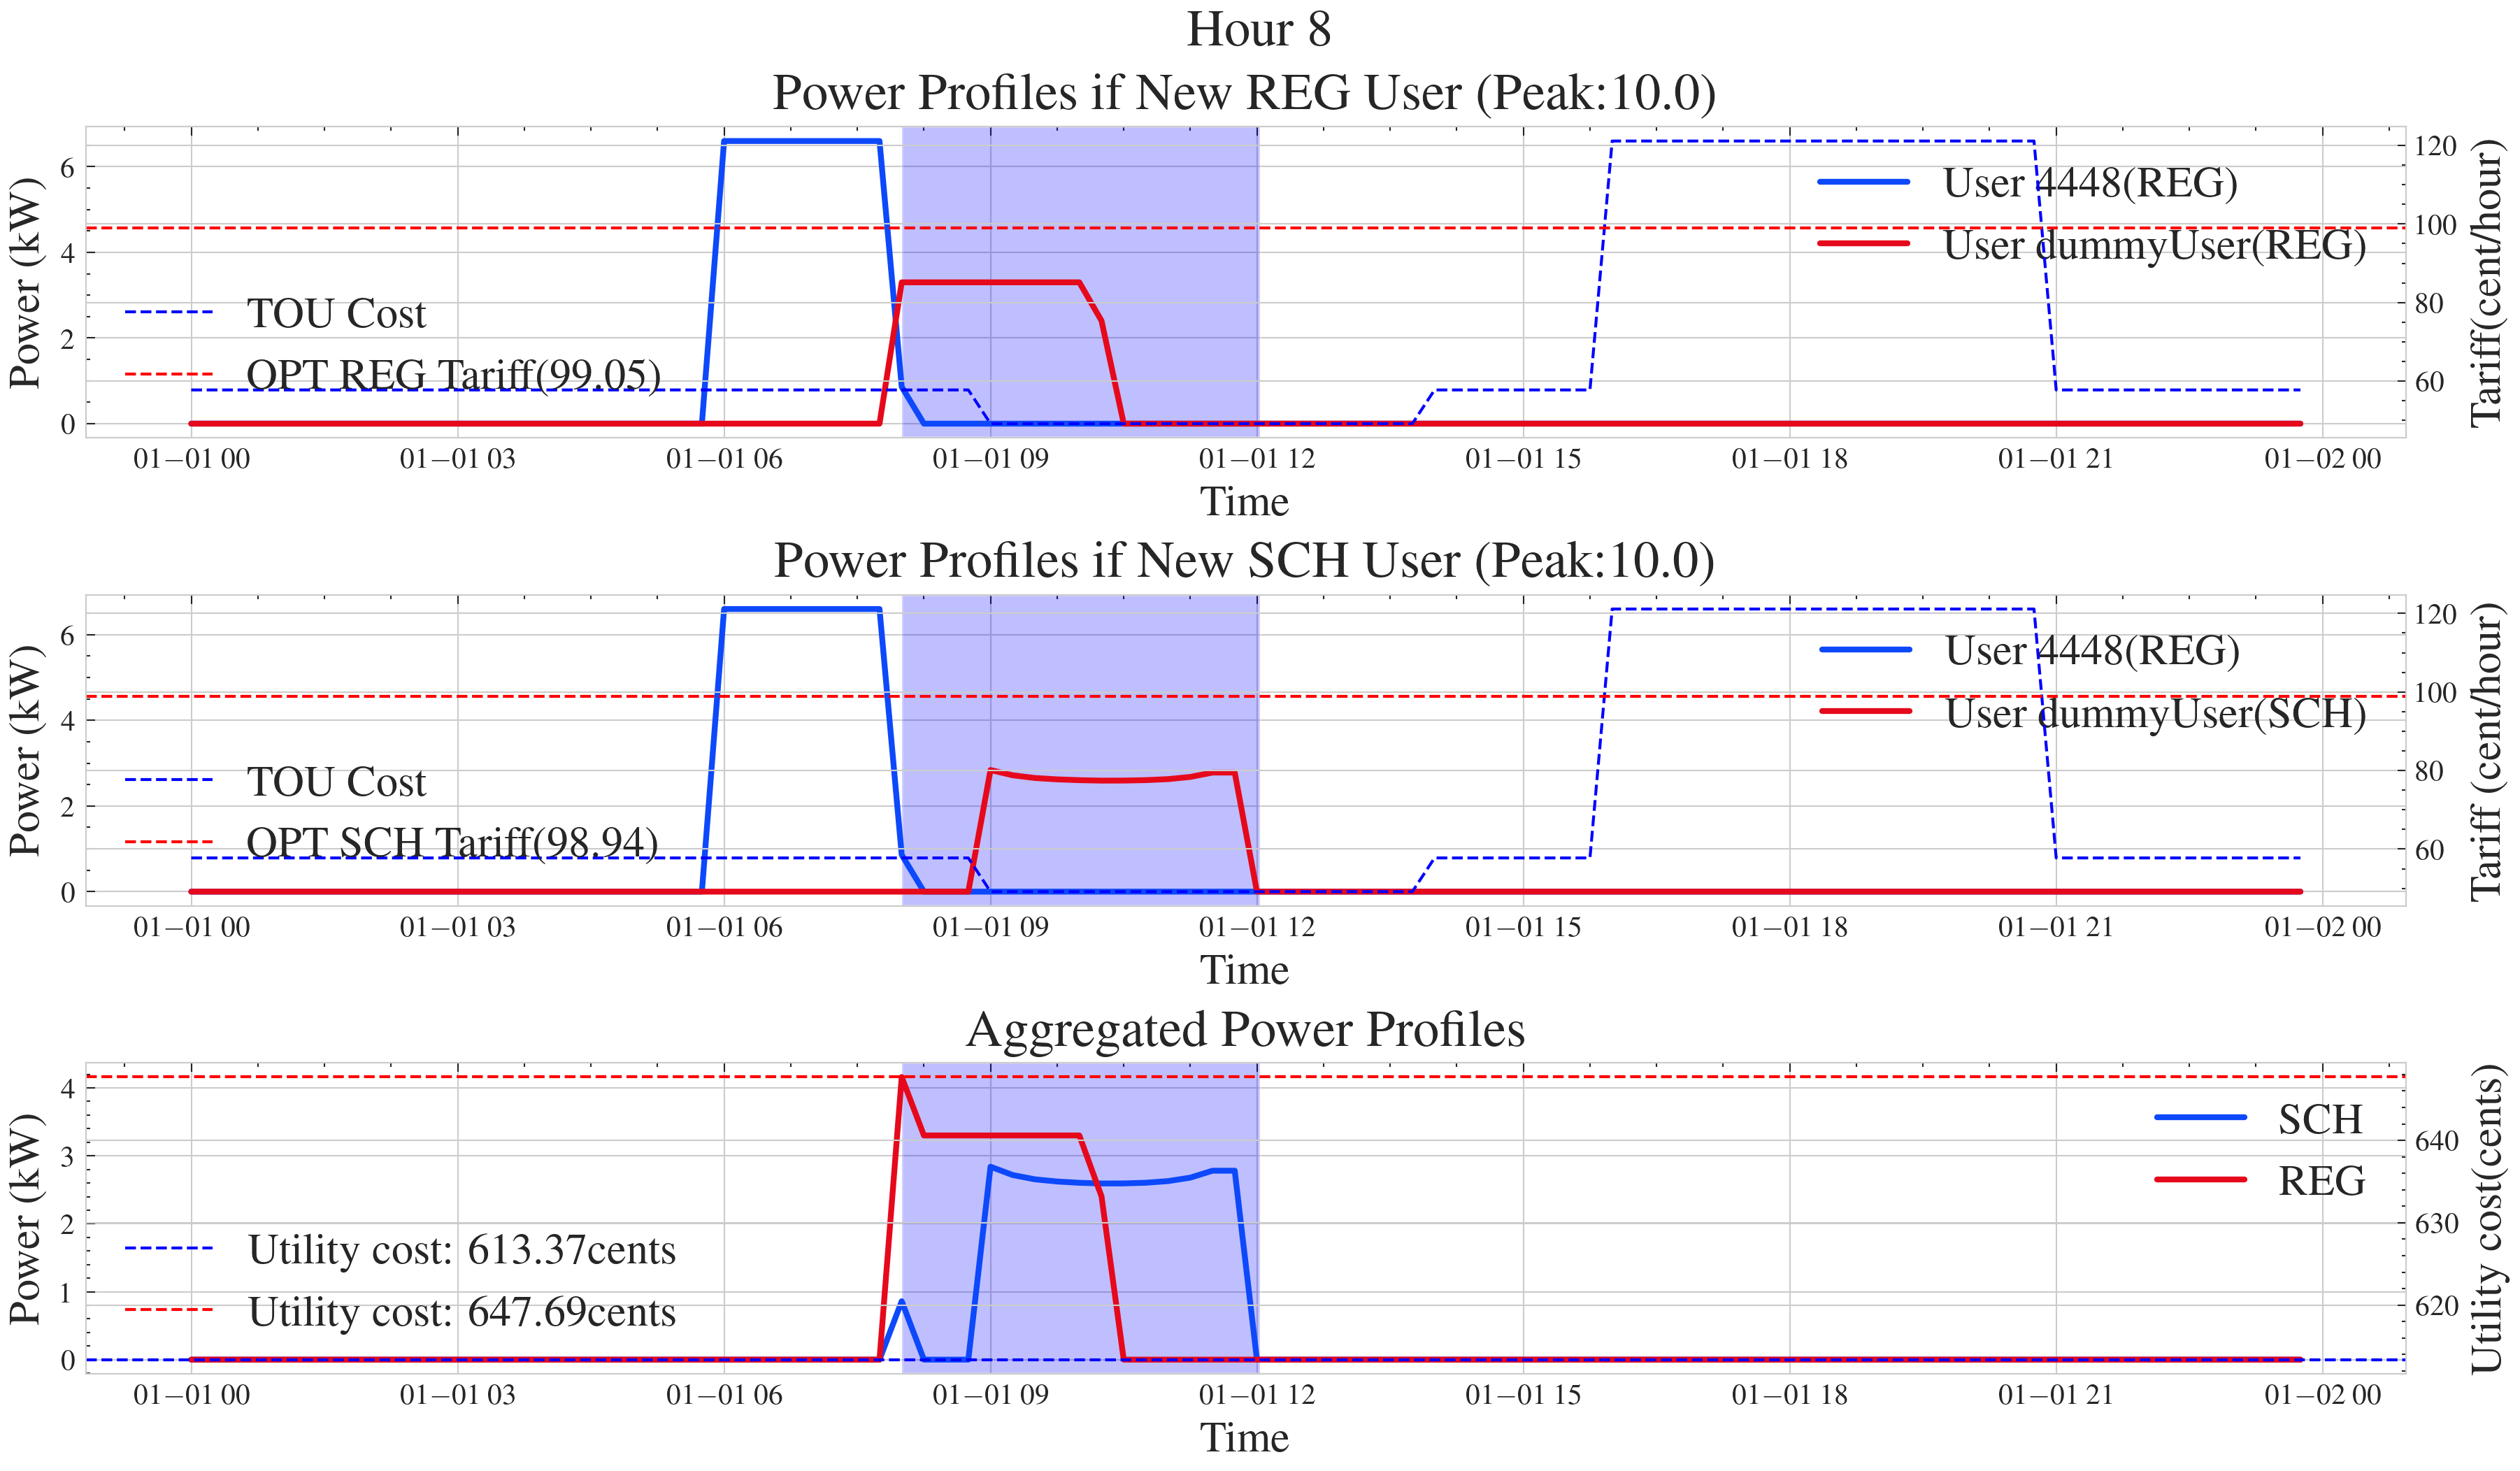

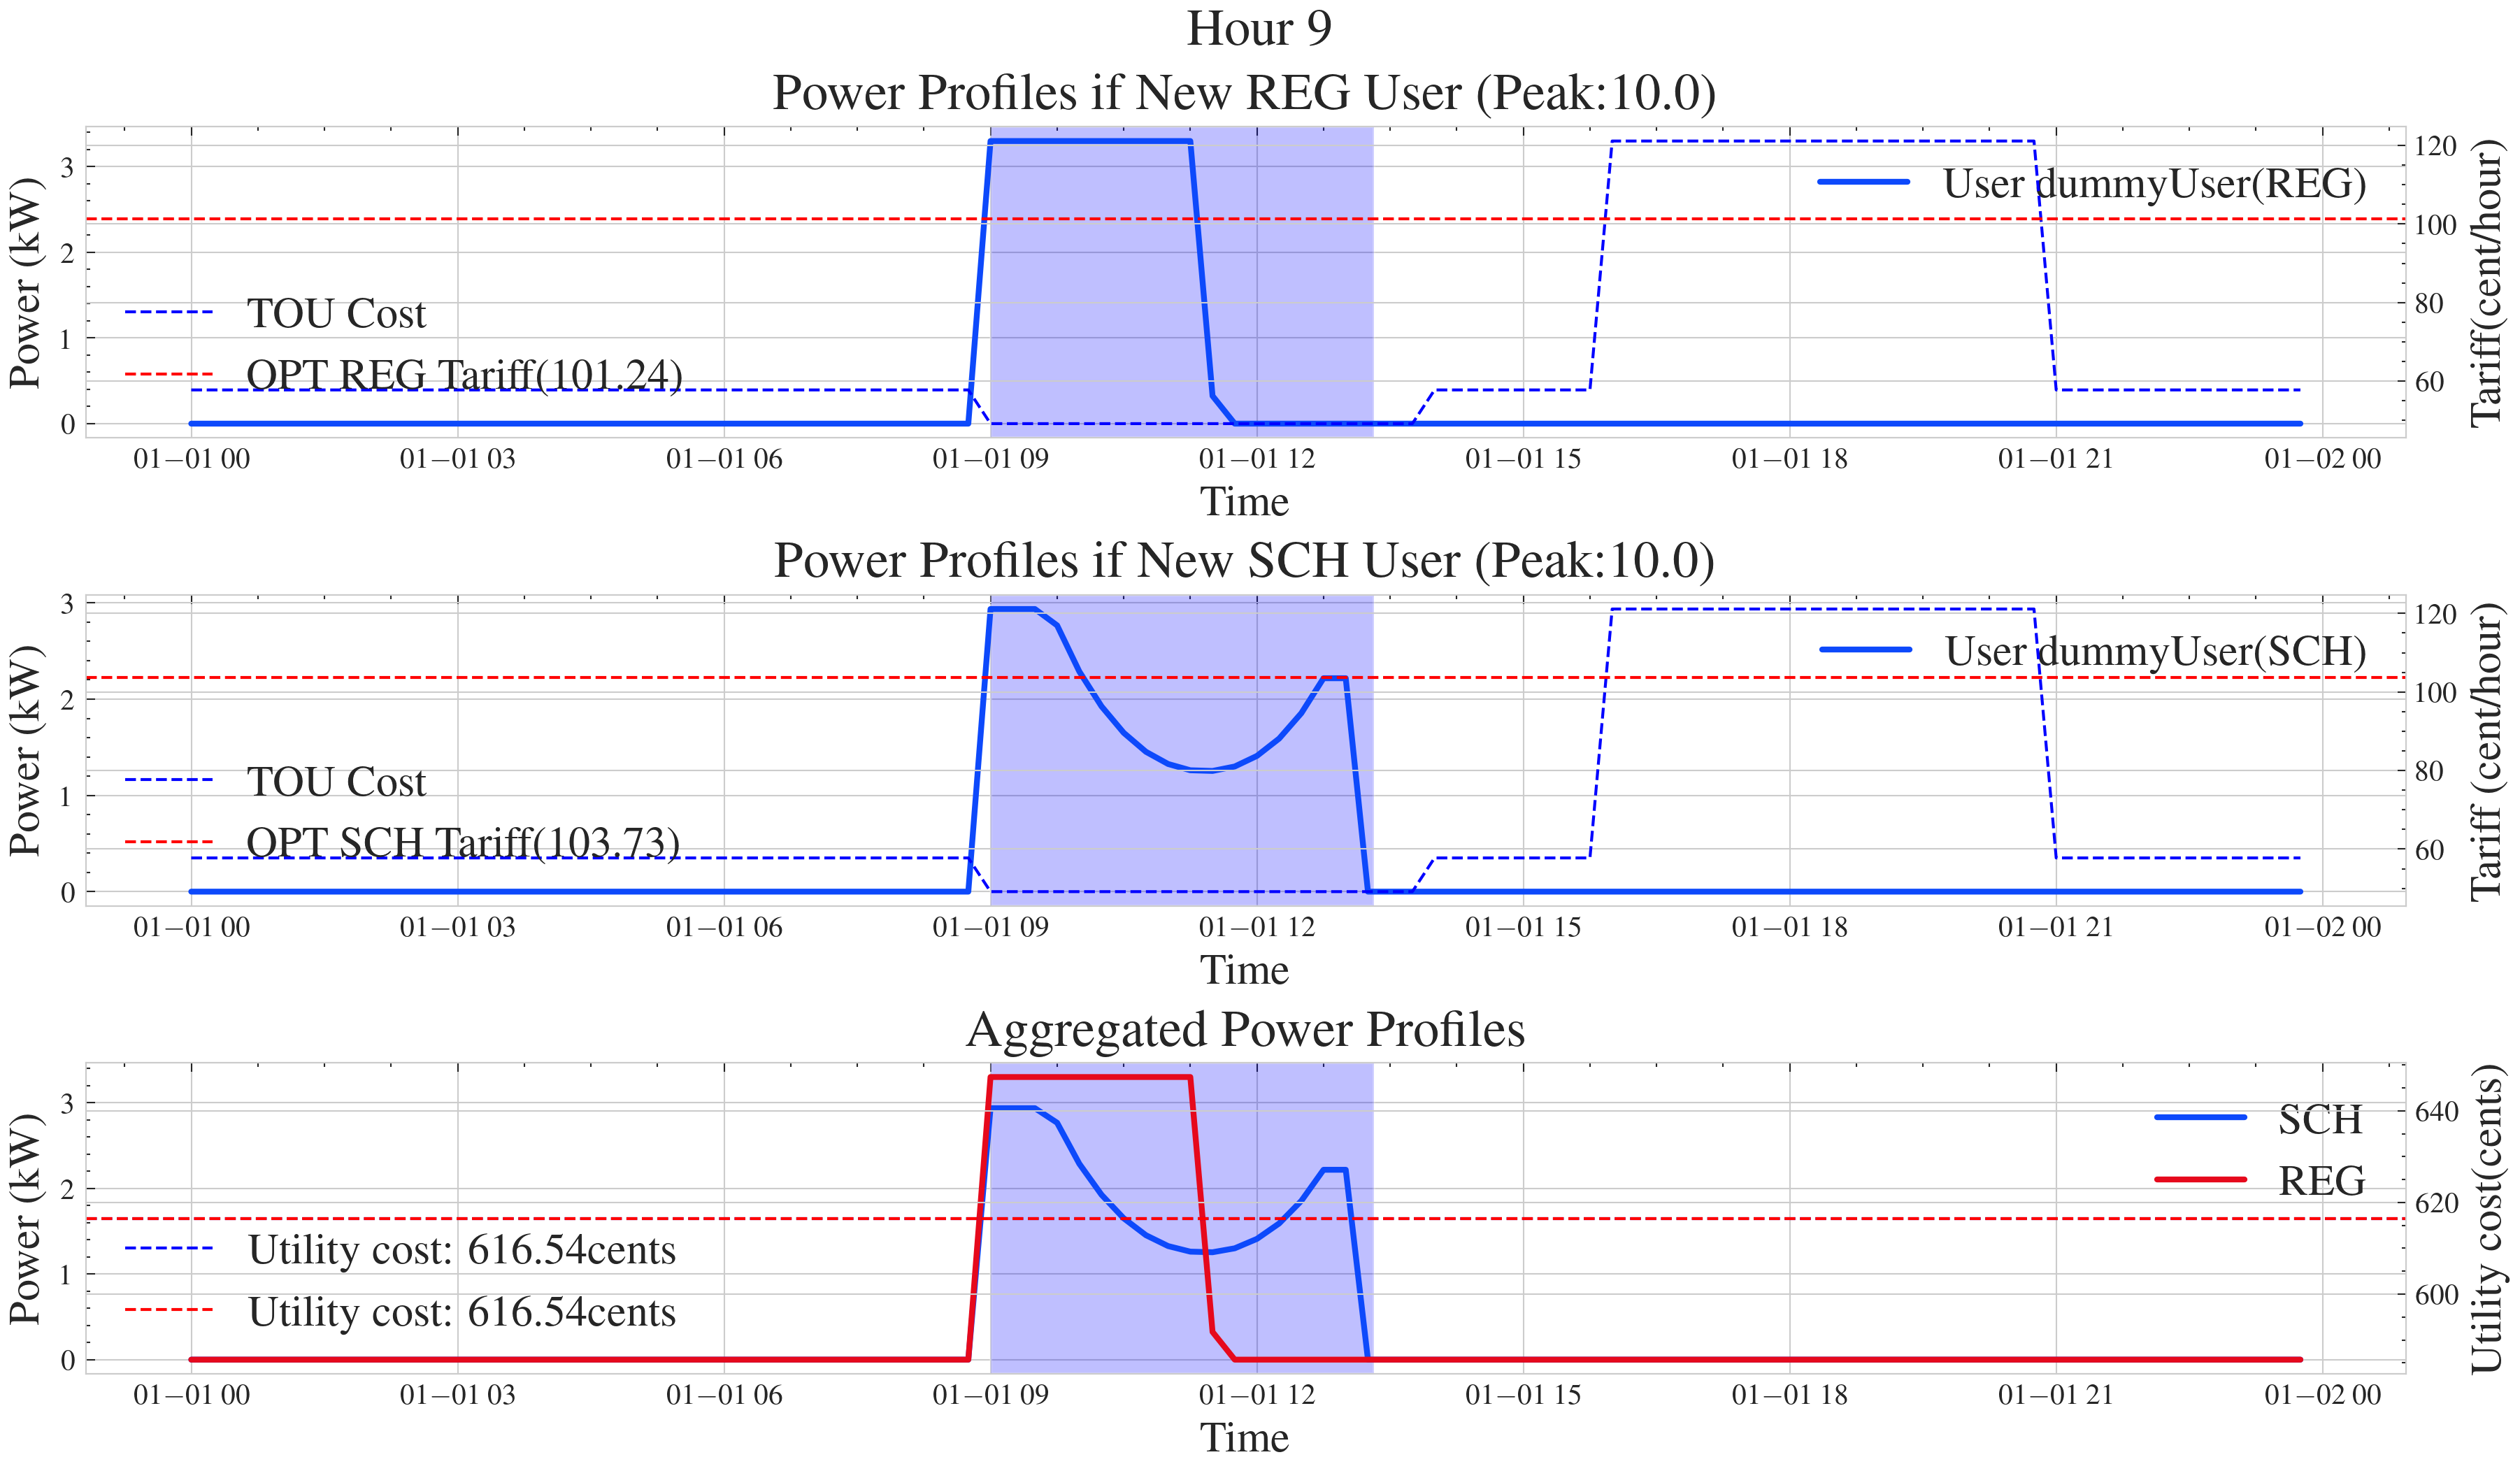

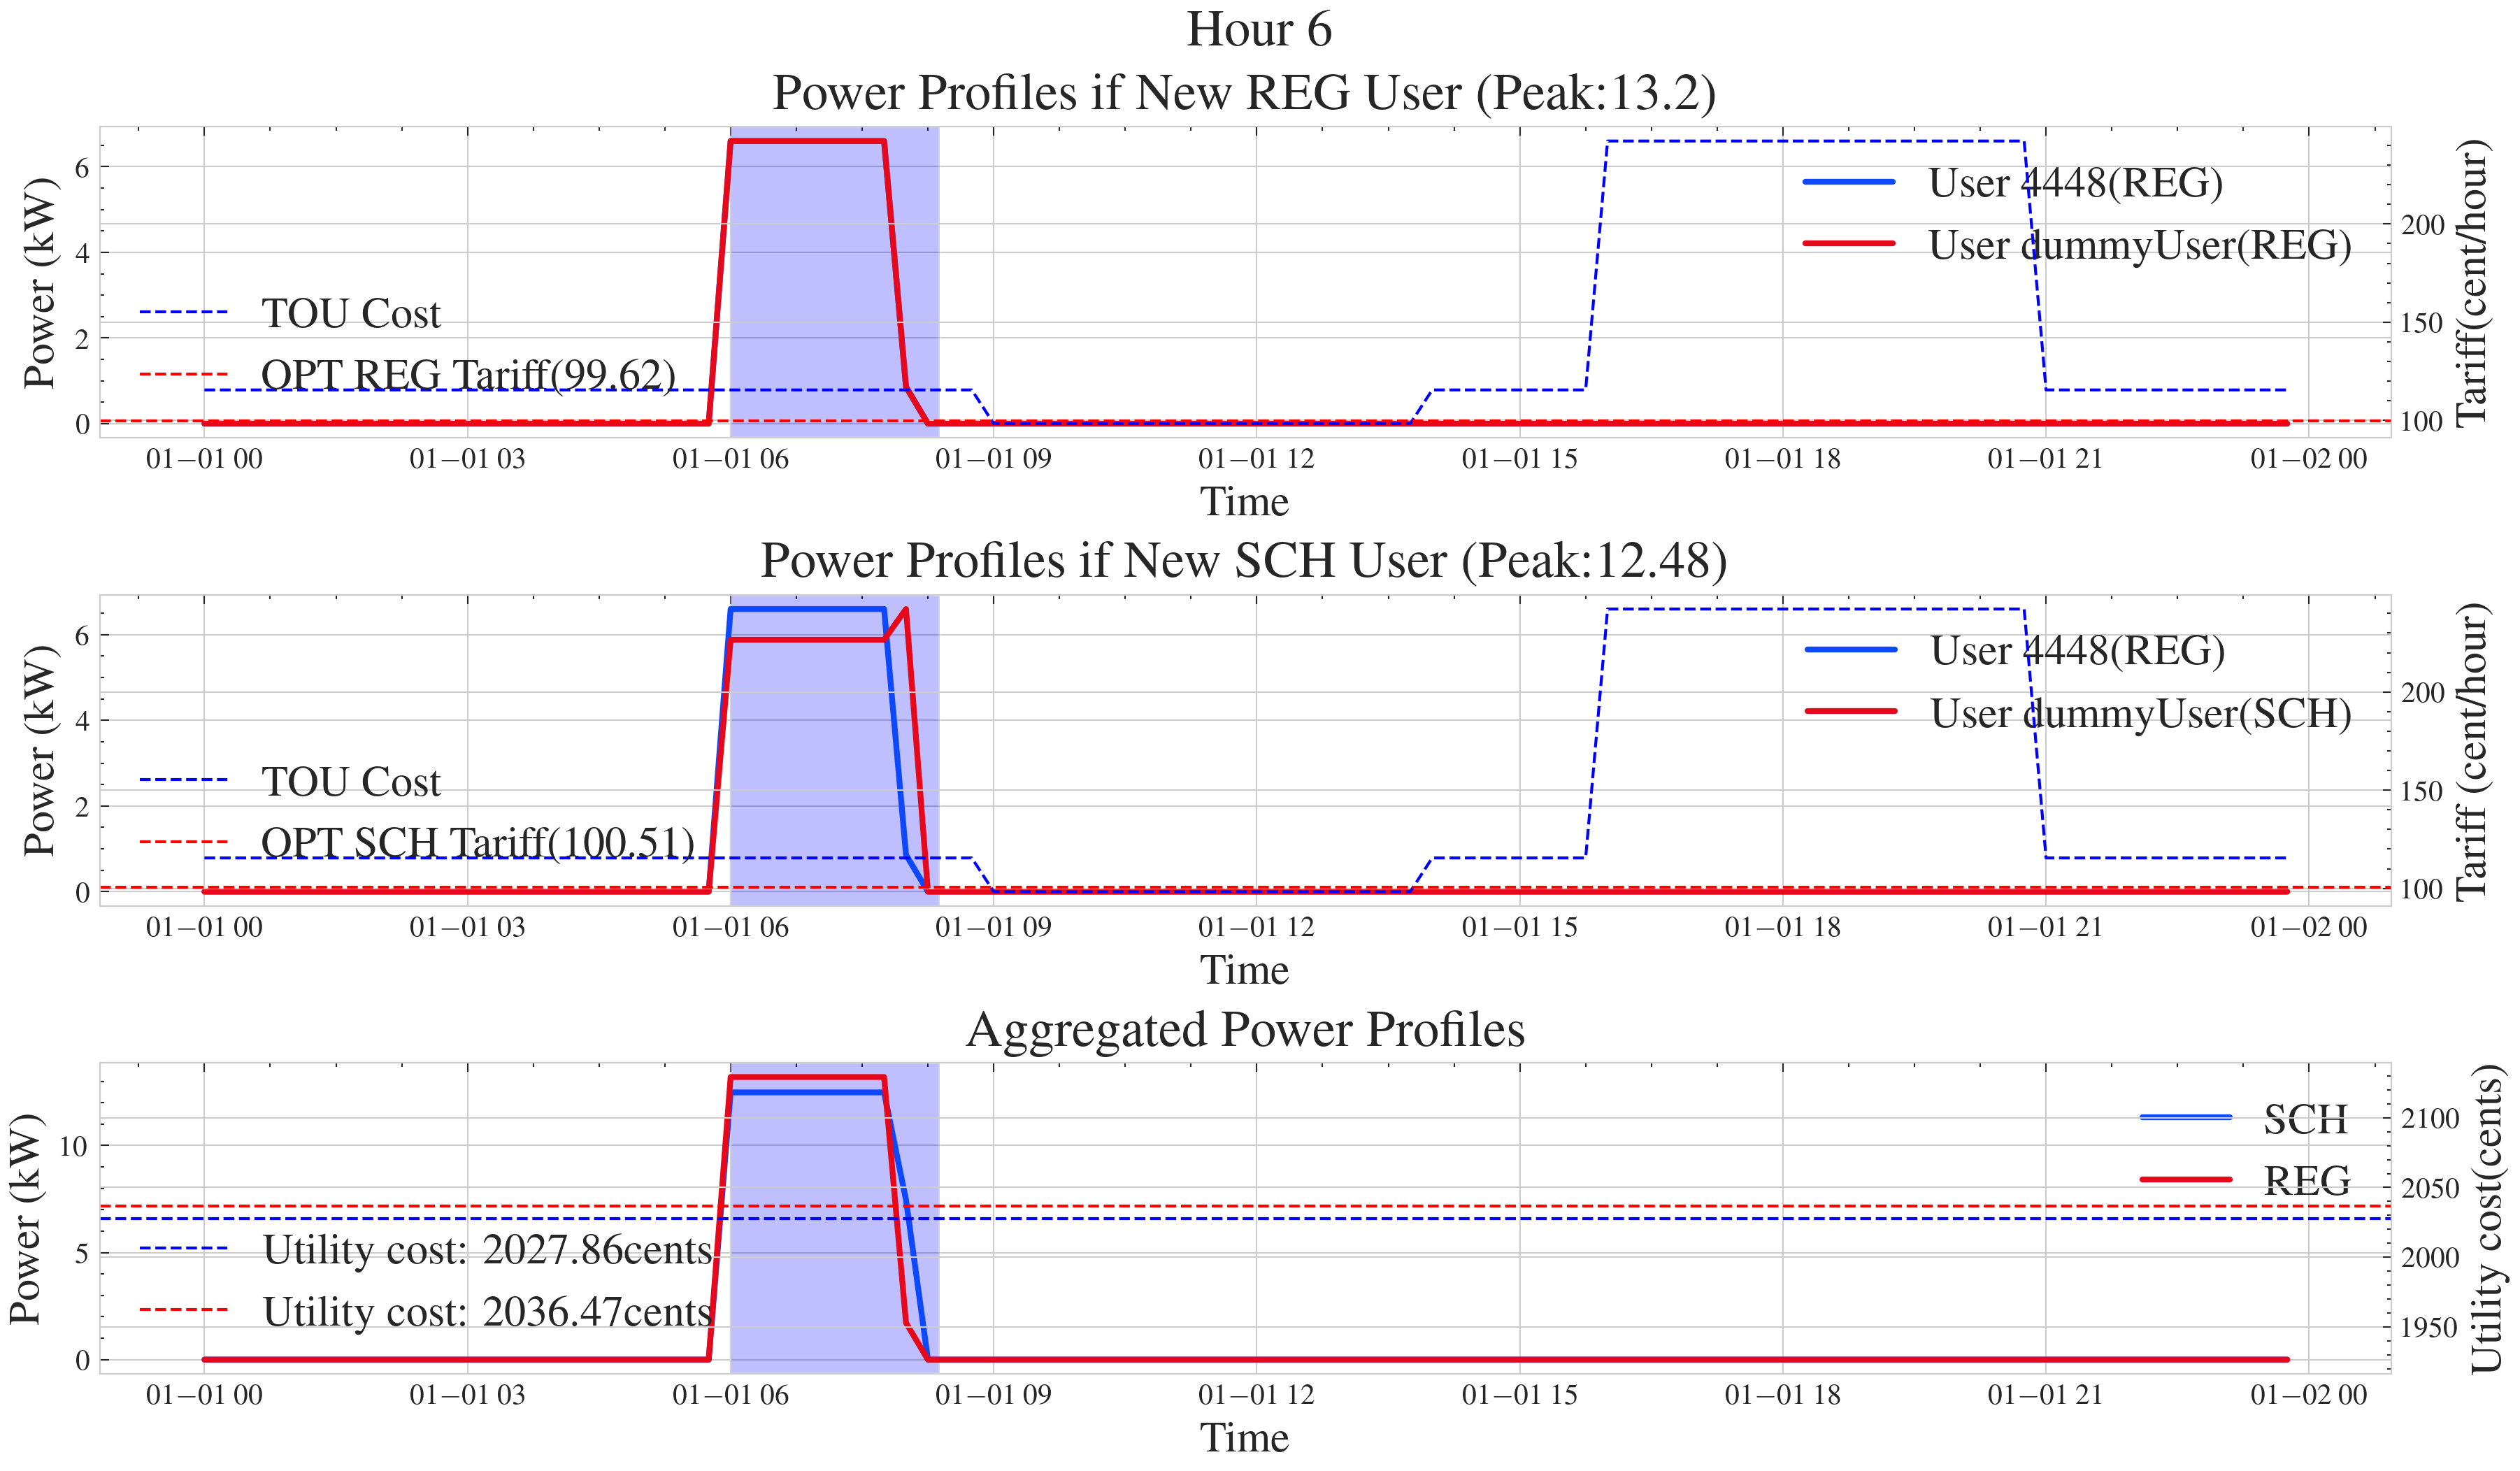

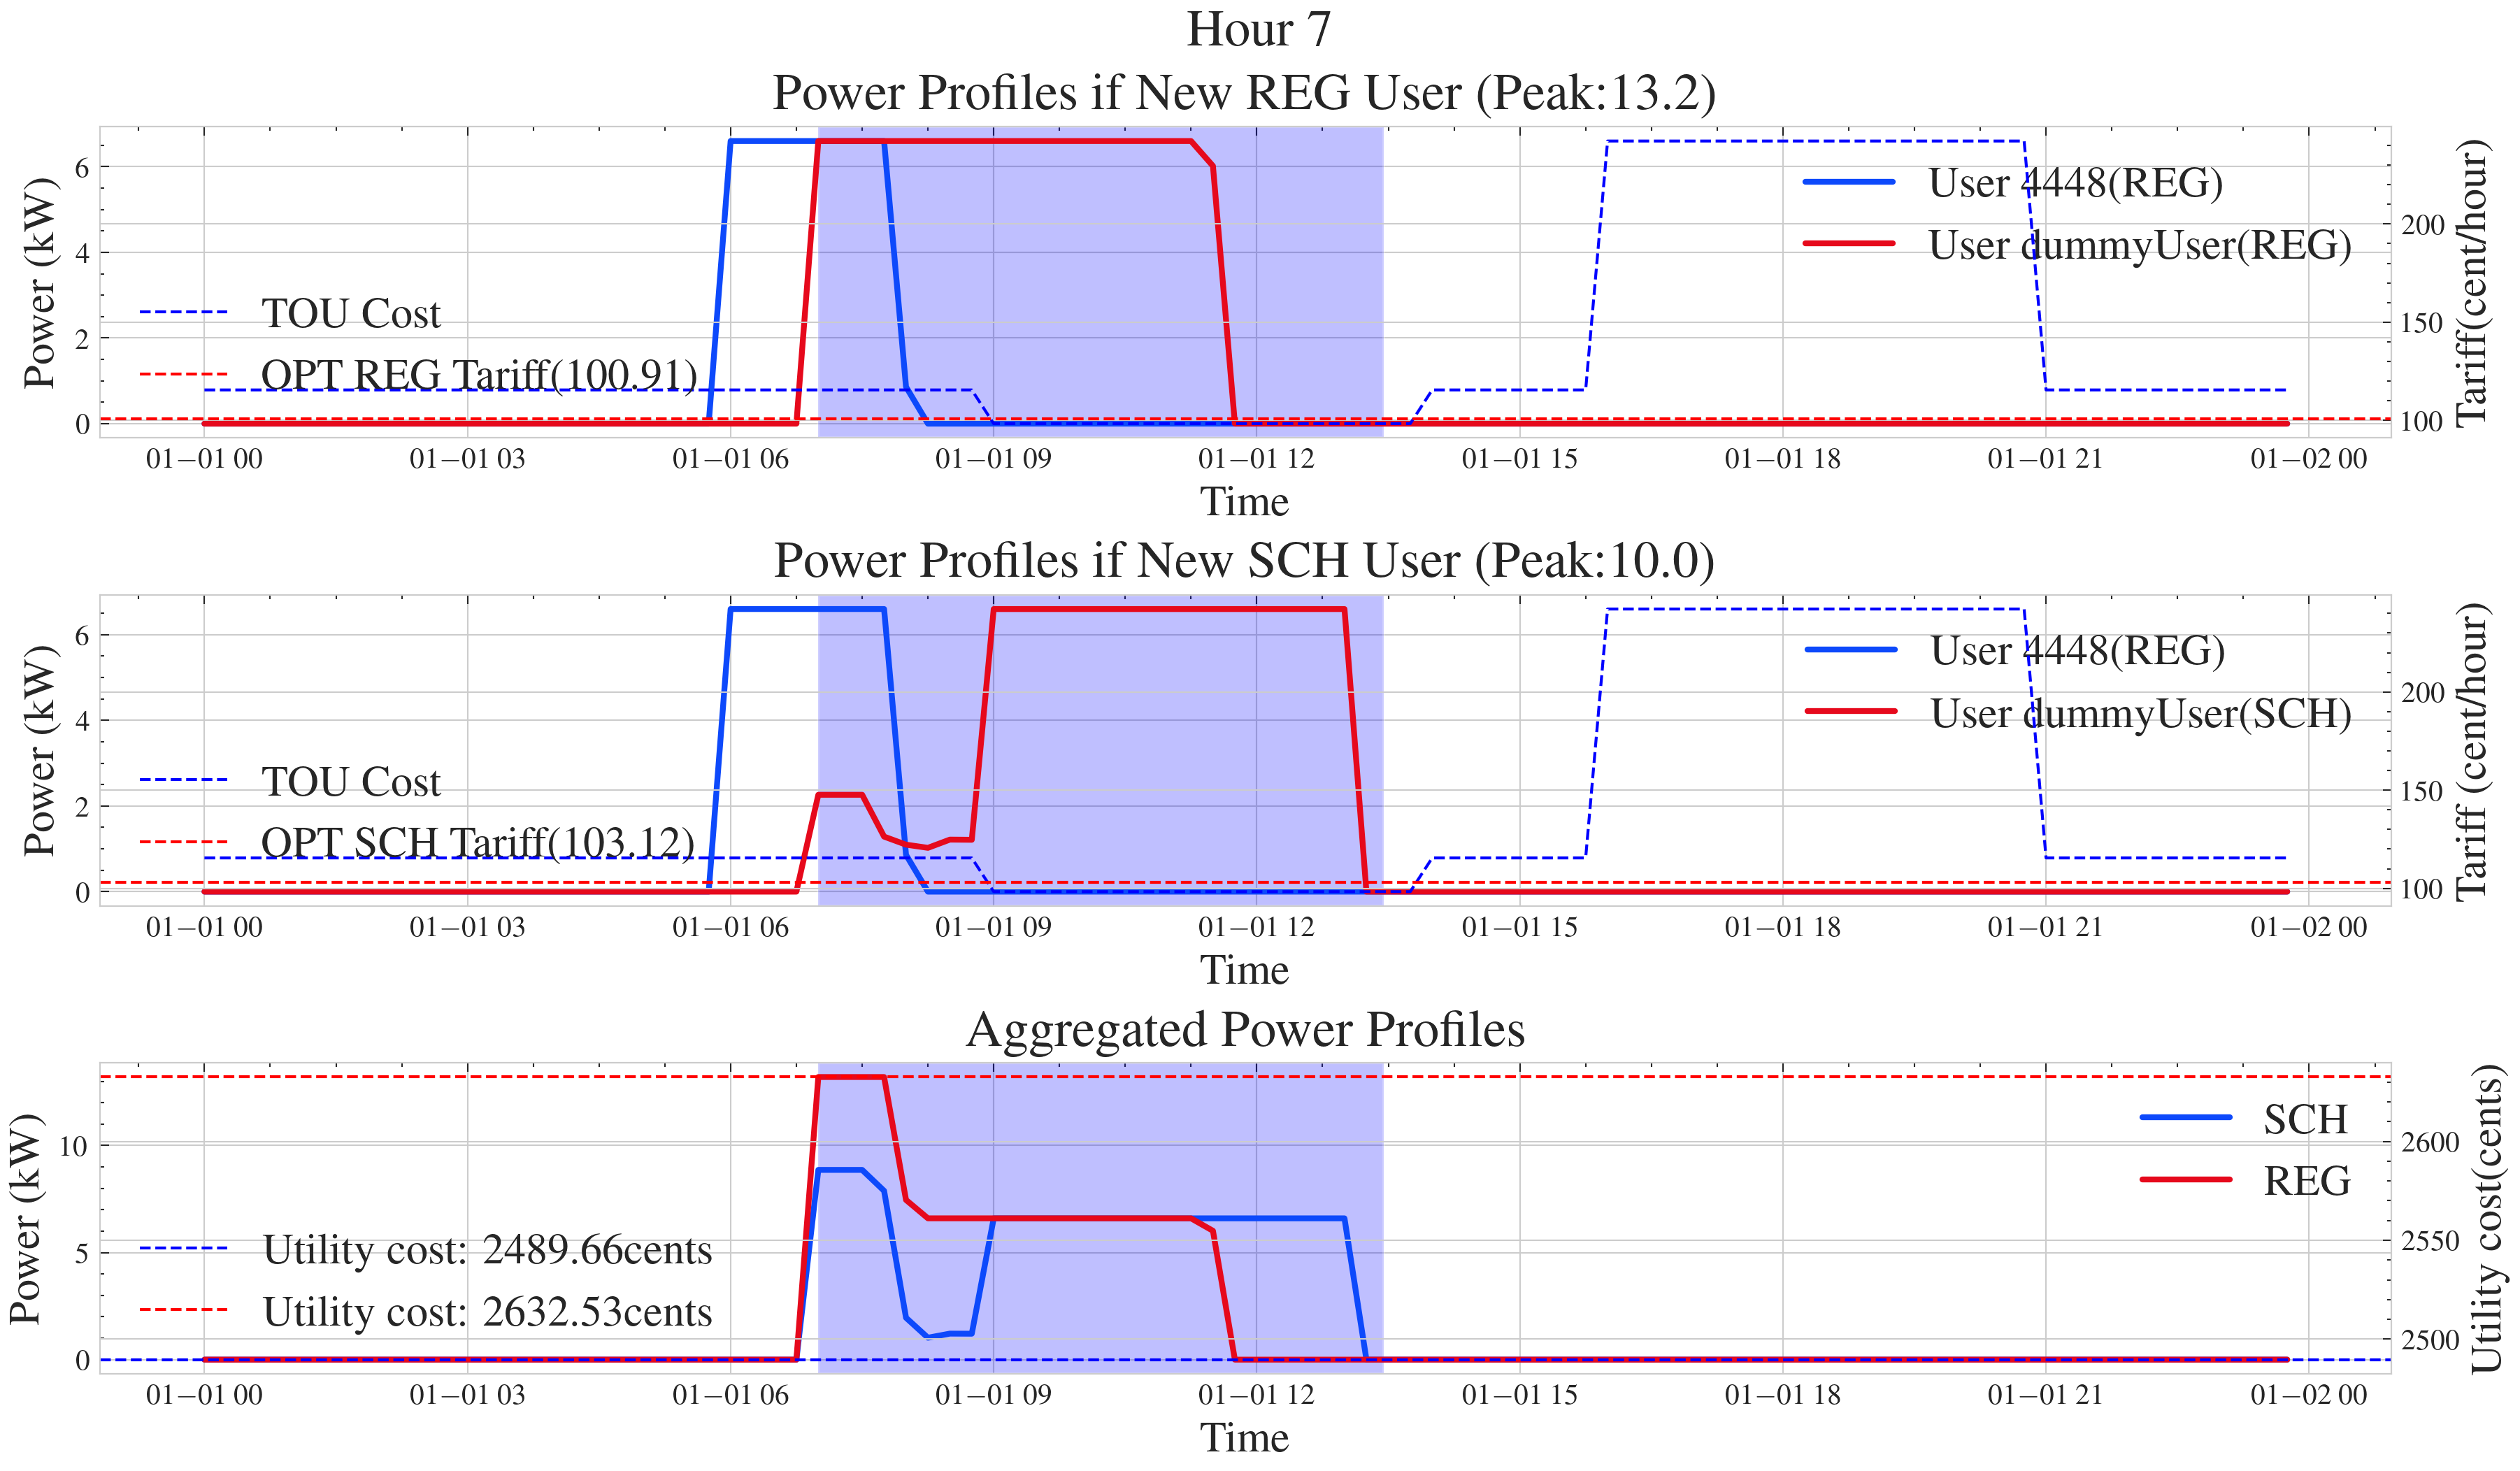

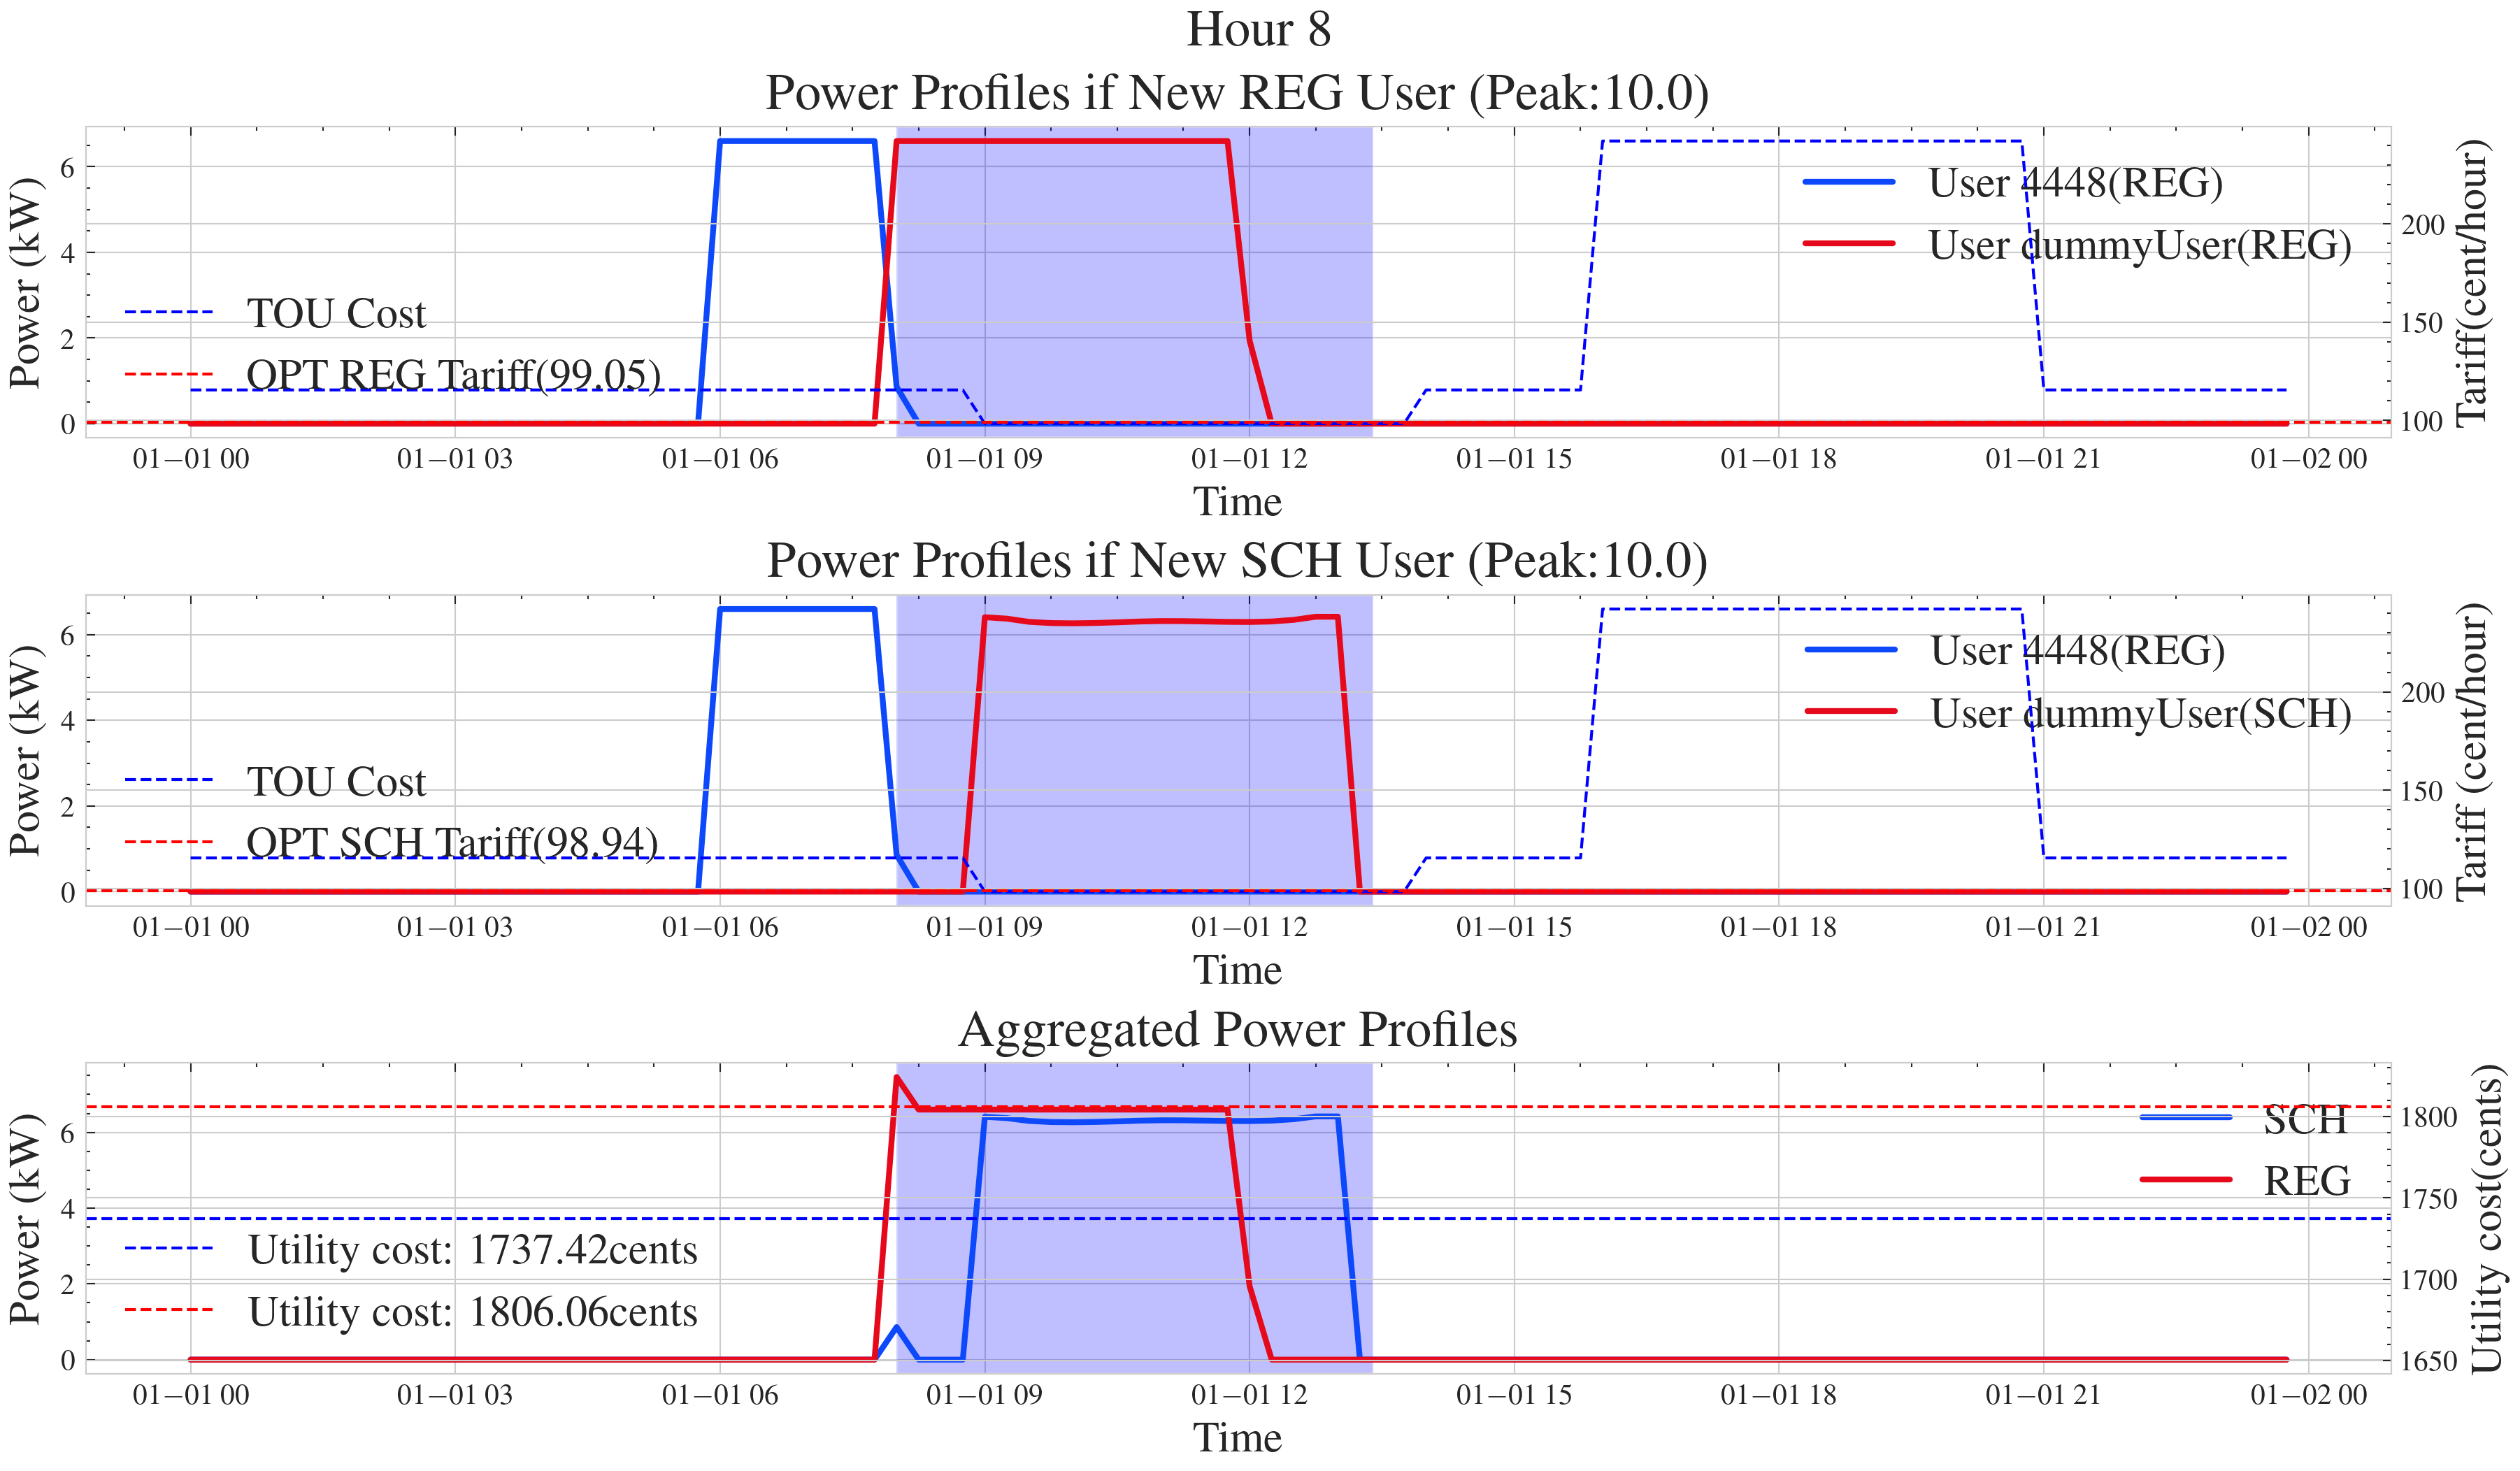

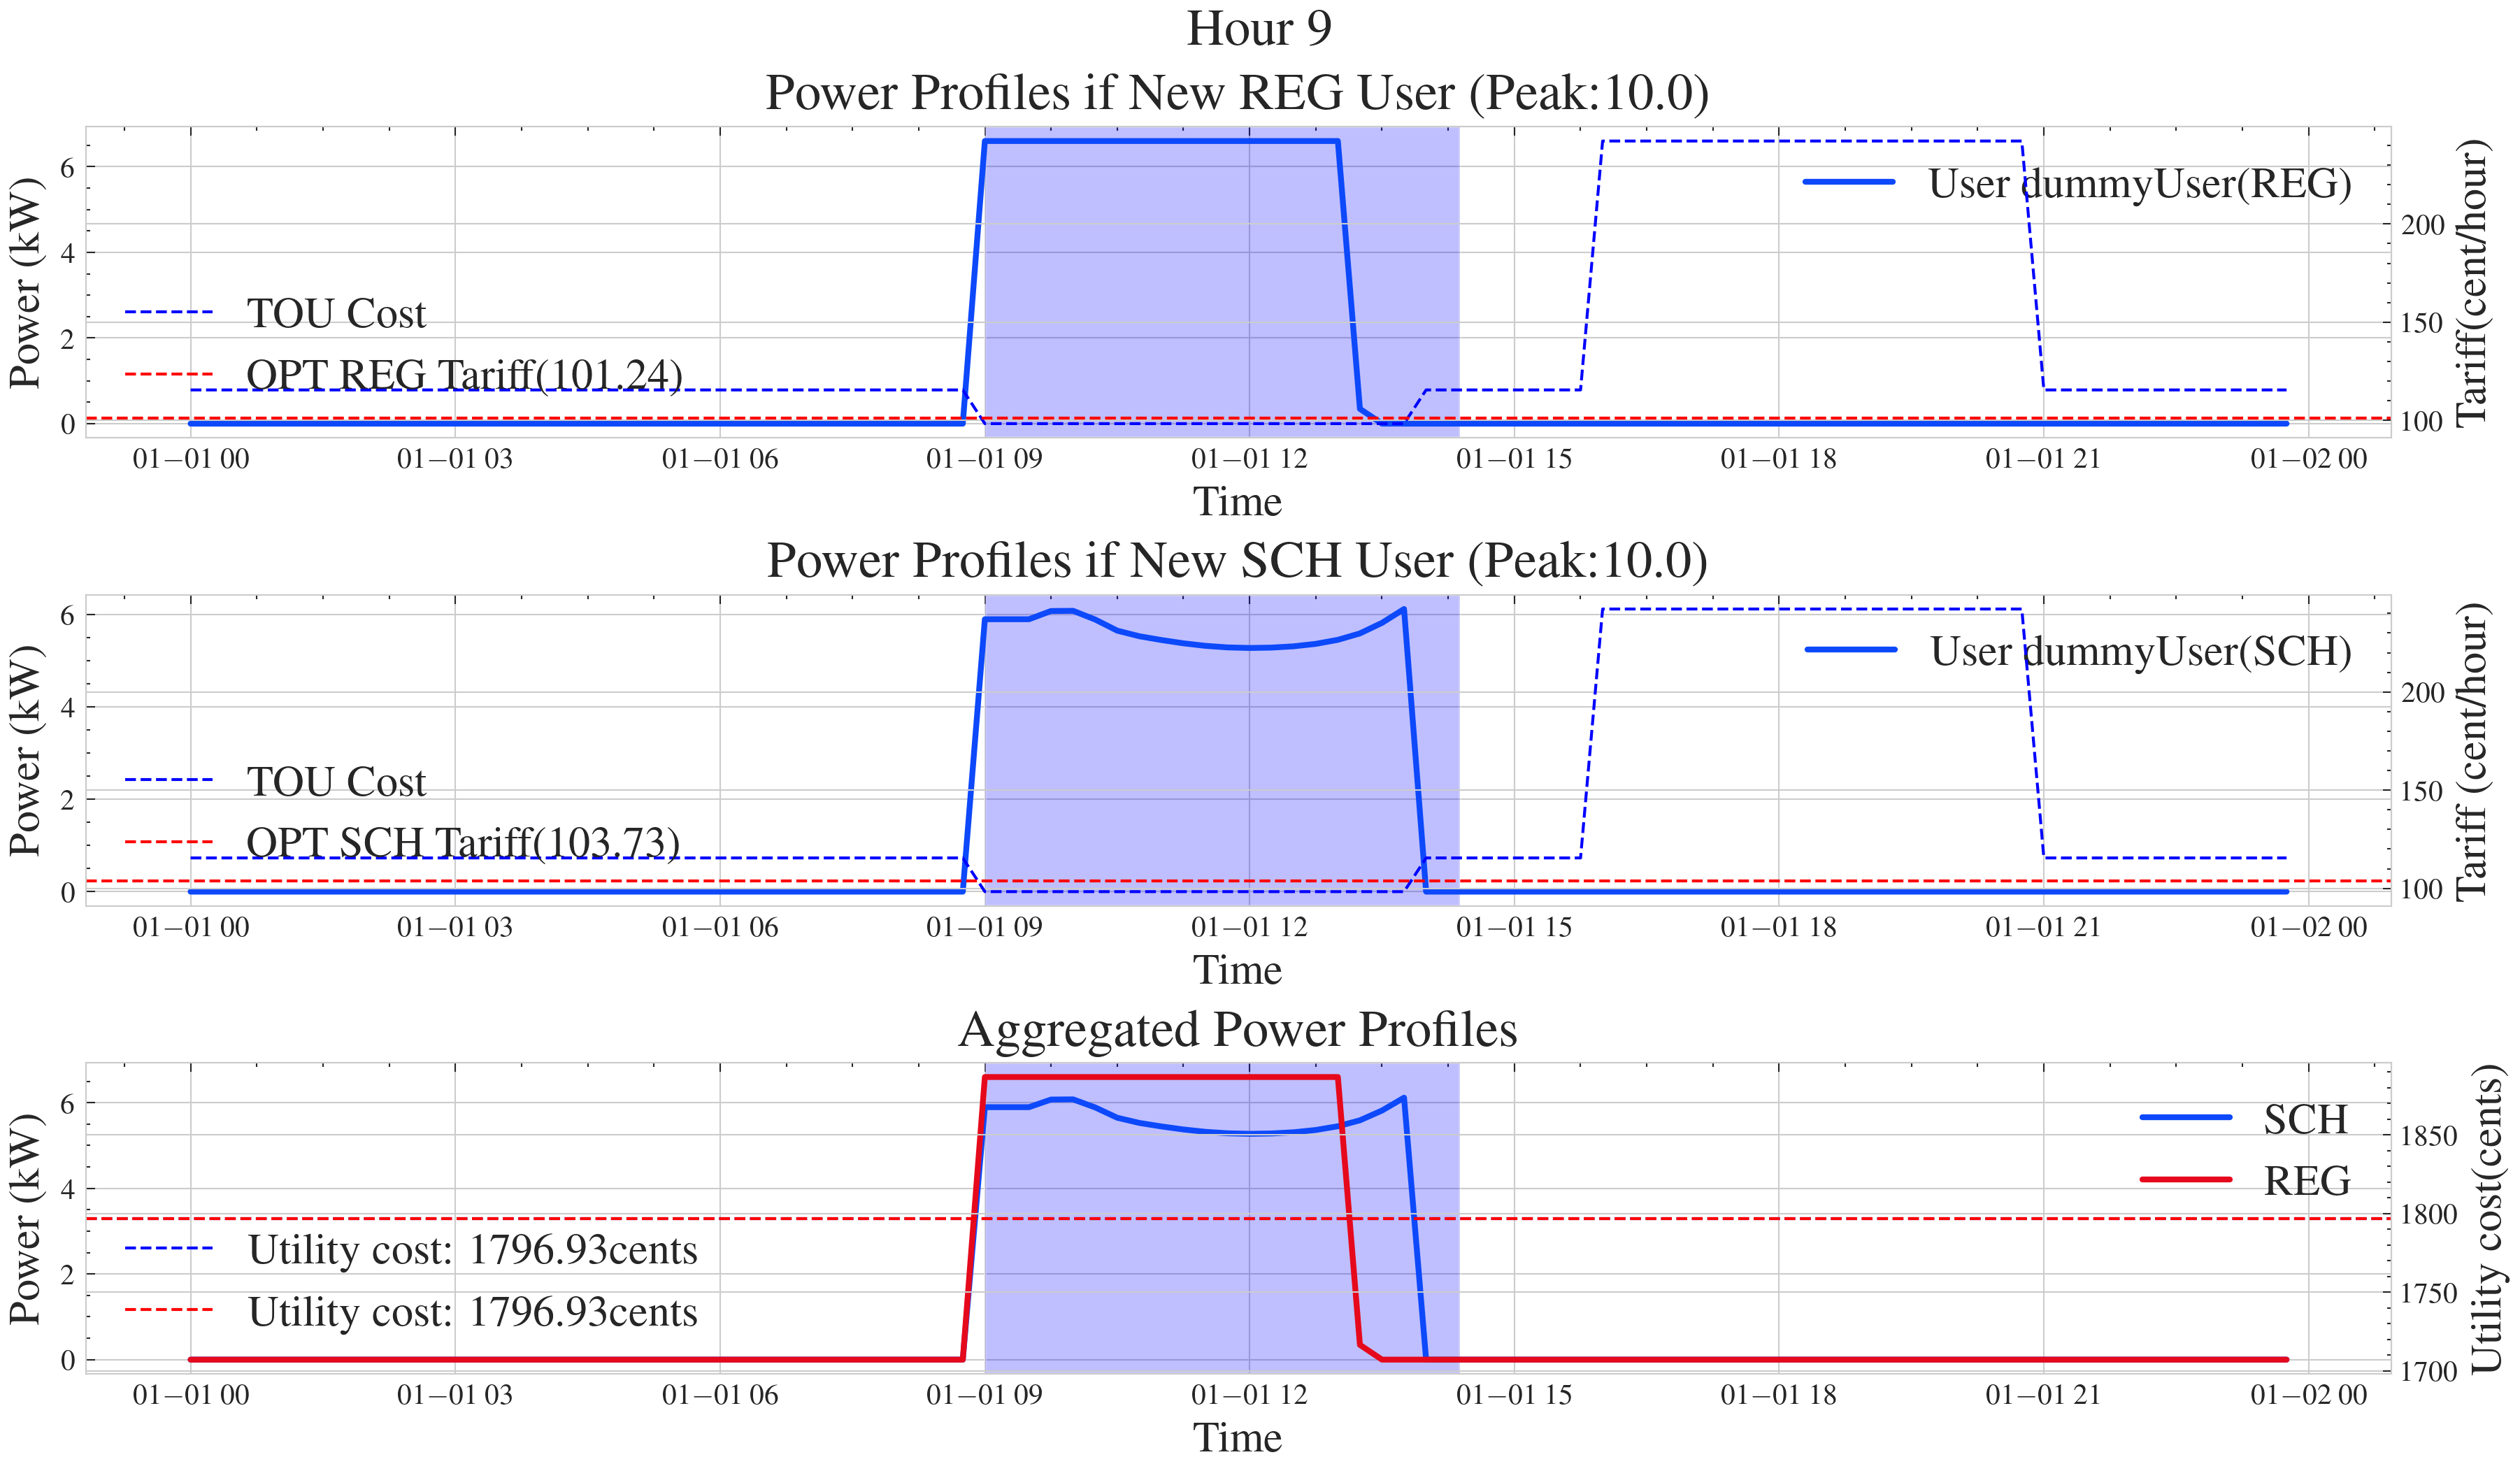

In [40]:
for highPower in [0, 1]:
    for hour in range(6, 10):
        plot_power_profiles(TOU_tariff, States, expected_demand, hour, highPower, delta_t=0.25)